# Aligned Baselines

Goal: investigate the agreement between integrated gradients and activation patching when the baselines are similar, across a variety of circuit tasks.

- Indirect Object Identification (Wang et al, 2023): consists of inputs like “When Mary and John went to the store, John gave a bottle of milk to”; models are expected to predict “Mary”. Performance measured using logit differences.

- Gender-Bias (Vig et al, 2020): designed to study gender bias in LMs. Gives models inputs like “The nurse said that”; biased models tend to complete this sentence with “she”. Performance measured using logit differences.

- Greater-Than (Hanna et al., 2023): models receive input like “The war lasted from the year 1741 to the year 17”, and must predict a valid two-digit end year, i.e. one that is greater than 41. Performance measured using probability differences.

- Capital–Country (Hanna et al., 2024): models receive input like “Tirana, the capital of” and must output the corresponding country (Albania). Corrupted instances contain another capital (e.g. Brasilia) instead. Performance measured using logit differences.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, greater_than_prob_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Indirect Object Identification

### Experiment

In [3]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [ ]:
ioi_ig_mlp, ioi_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_ig_mlp, "results/aligned/ioi/ig_mlp.pt")
torch.save(ioi_ig_attn, "results/aligned/ioi/ig_attn.pt")

In [6]:
ioi_ap_mlp, ioi_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(ioi_ap_mlp, "results/aligned/ioi/ap_mlp.pt")
torch.save(ioi_ap_attn, "results/aligned/ioi/ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

### Analysis

In [ ]:
ioi_ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ioi_ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")
ioi_ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ioi_ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

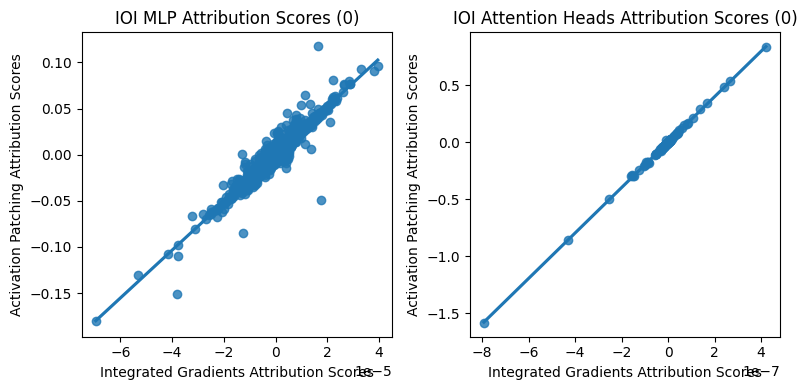

Correlation coefficient for neurons: 0.9781080393095622
Correlation coefficient for attention heads: 0.9996766519539678


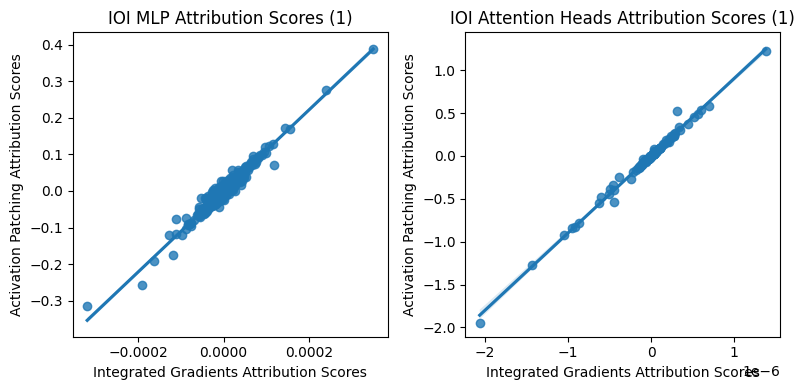

Correlation coefficient for neurons: 0.9806869207736839
Correlation coefficient for attention heads: 0.9951896333430784


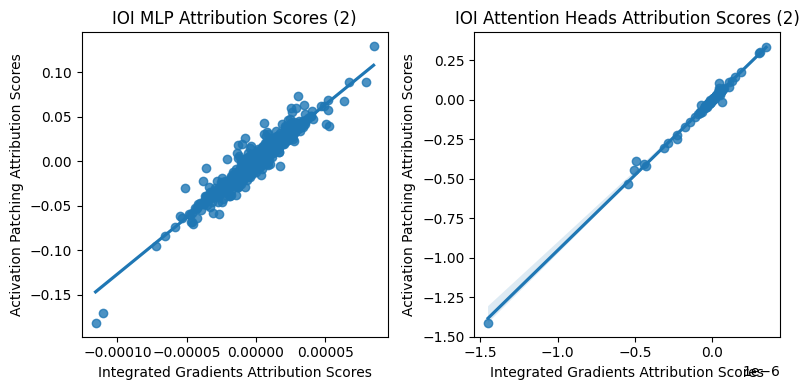

Correlation coefficient for neurons: 0.9757320311419592
Correlation coefficient for attention heads: 0.9967339352568451


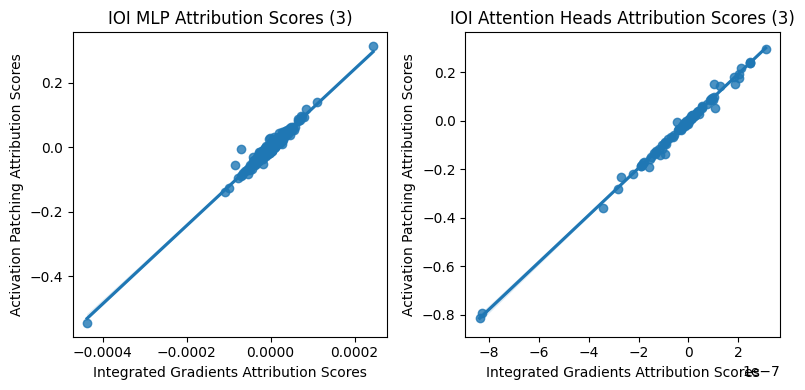

Correlation coefficient for neurons: 0.9839111497004035
Correlation coefficient for attention heads: 0.9967403119594928


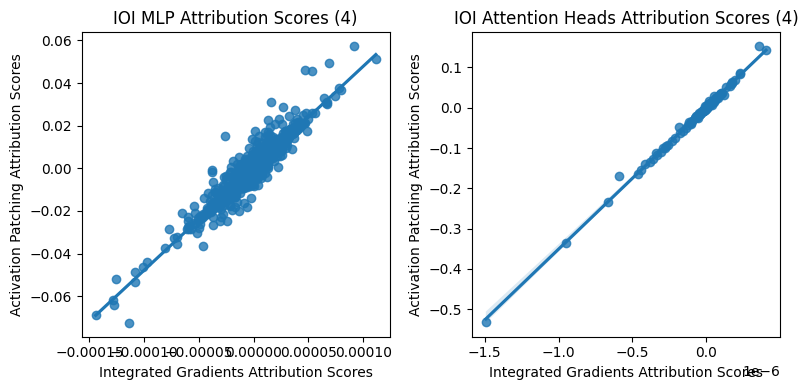

Correlation coefficient for neurons: 0.9670389843591409
Correlation coefficient for attention heads: 0.997777206804122


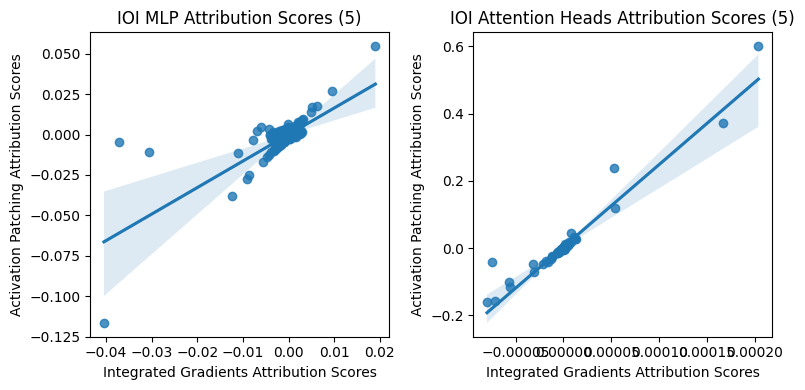

Correlation coefficient for neurons: 0.7595119694726896
Correlation coefficient for attention heads: 0.9632317632684859


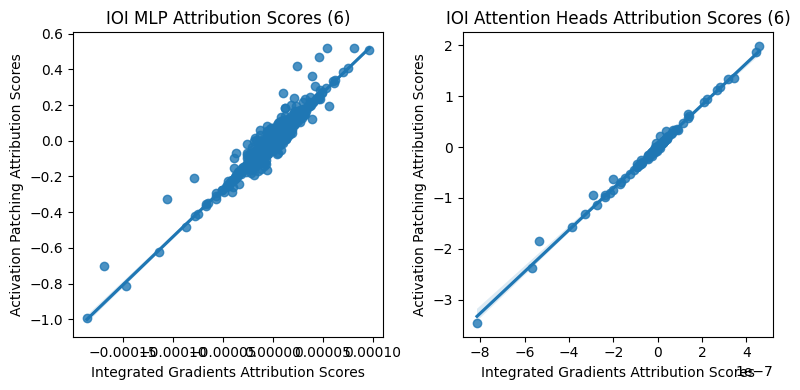

Correlation coefficient for neurons: 0.974143906860196
Correlation coefficient for attention heads: 0.9965606172404633


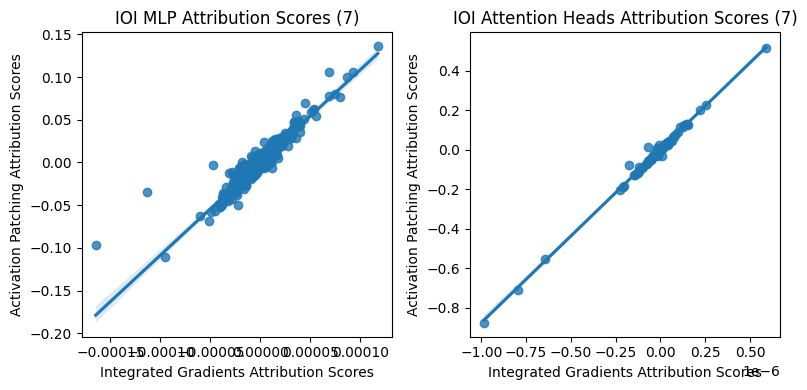

Correlation coefficient for neurons: 0.9665006507599821
Correlation coefficient for attention heads: 0.996421768204579


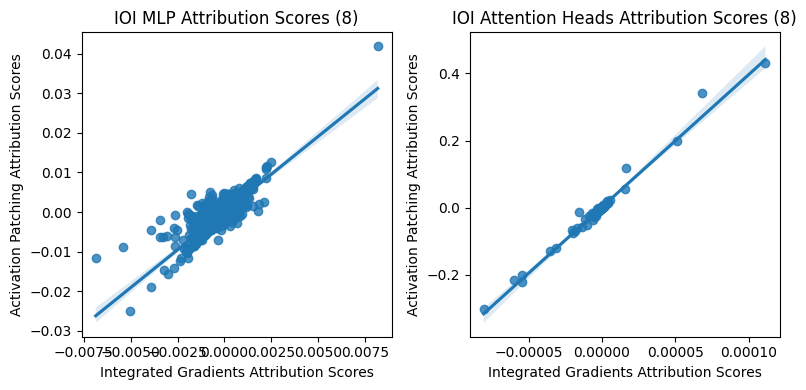

Correlation coefficient for neurons: 0.8802485892531234
Correlation coefficient for attention heads: 0.9904691626179392


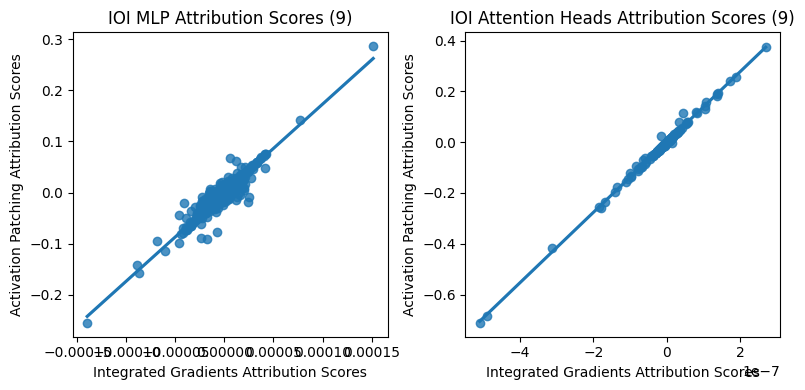

Correlation coefficient for neurons: 0.9687053827582426
Correlation coefficient for attention heads: 0.9978241406180225


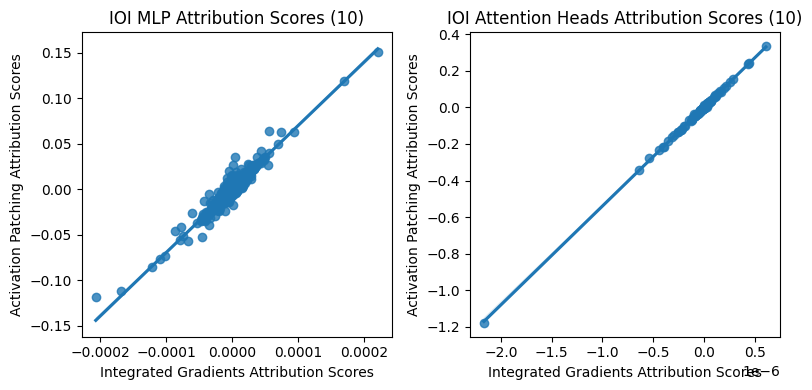

Correlation coefficient for neurons: 0.9758757111996507
Correlation coefficient for attention heads: 0.9996404085985838


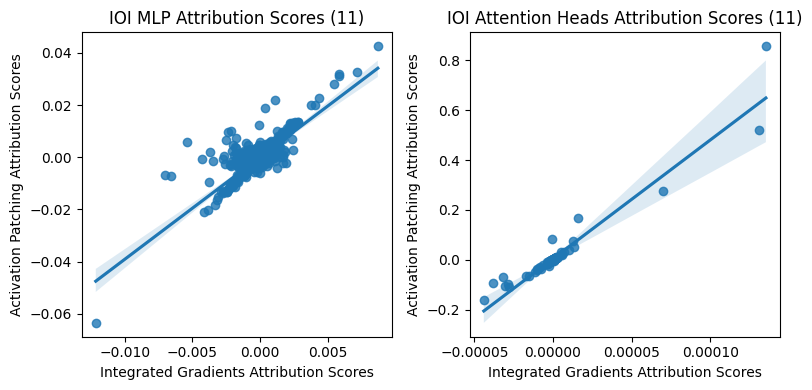

Correlation coefficient for neurons: 0.848471160446645
Correlation coefficient for attention heads: 0.9603611097048859


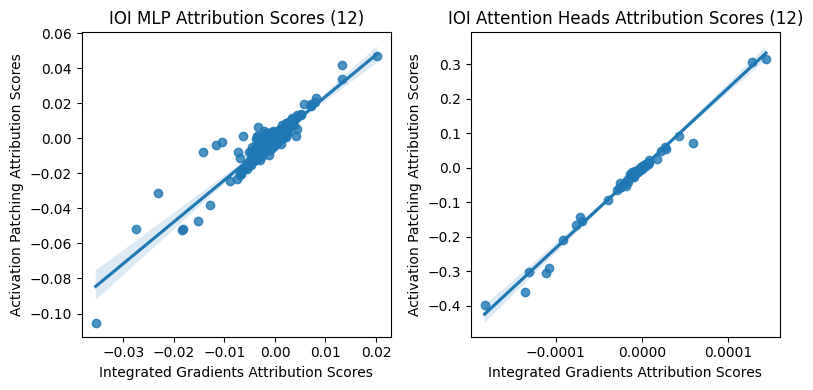

Correlation coefficient for neurons: 0.9307468143758958
Correlation coefficient for attention heads: 0.99246520911281


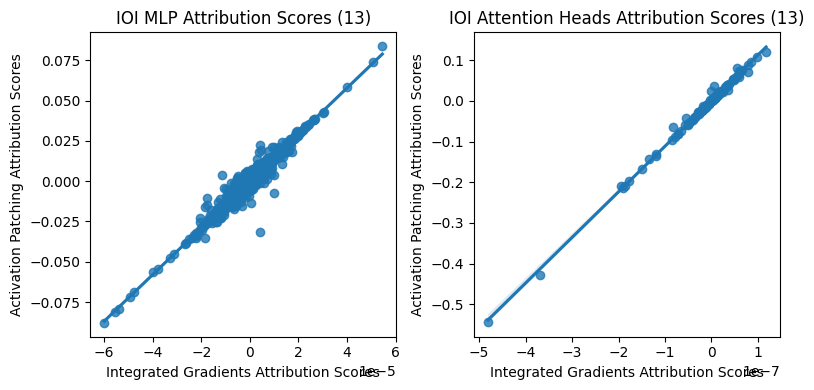

Correlation coefficient for neurons: 0.9860747877566793
Correlation coefficient for attention heads: 0.99756753244509


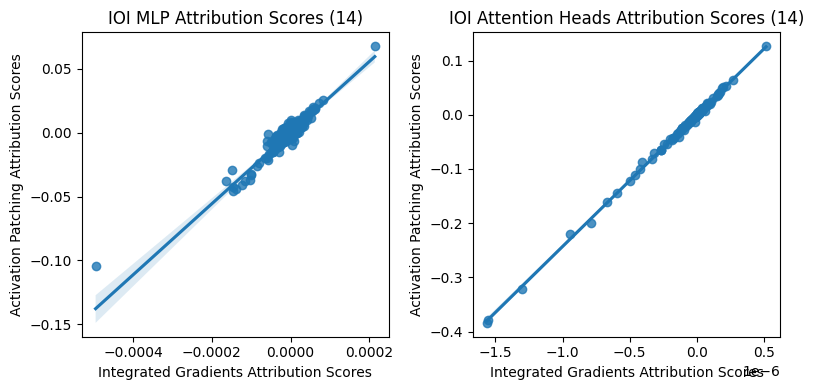

Correlation coefficient for neurons: 0.9635499080245447
Correlation coefficient for attention heads: 0.9993371062279203


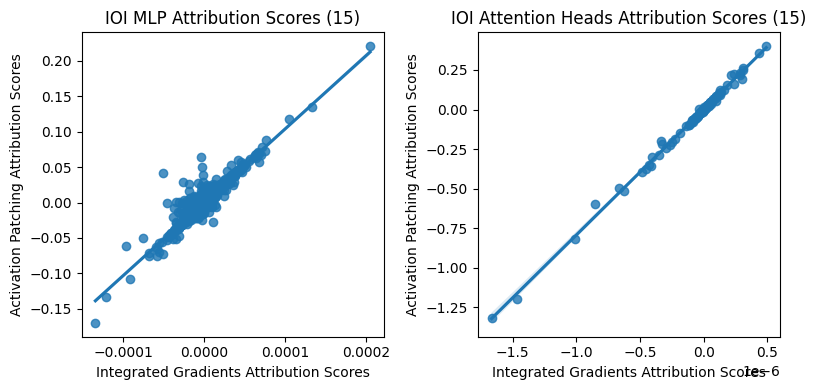

Correlation coefficient for neurons: 0.964284342247853
Correlation coefficient for attention heads: 0.9978986215715708


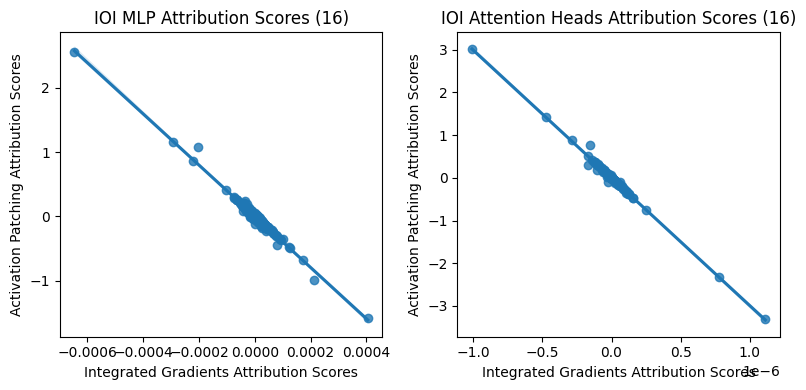

Correlation coefficient for neurons: -0.9917233582451694
Correlation coefficient for attention heads: -0.9969667504193191


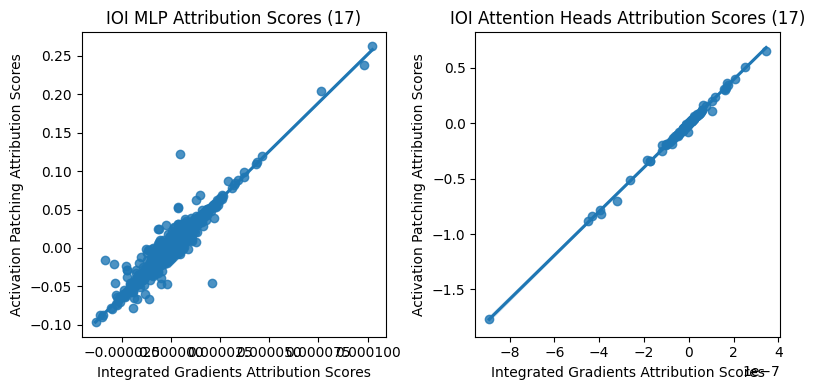

Correlation coefficient for neurons: 0.9758406846444825
Correlation coefficient for attention heads: 0.9982946006299958


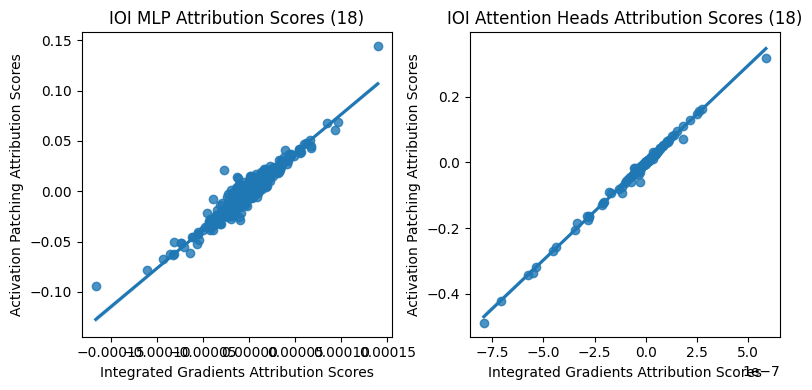

Correlation coefficient for neurons: 0.9748664523540953
Correlation coefficient for attention heads: 0.9972861310375883


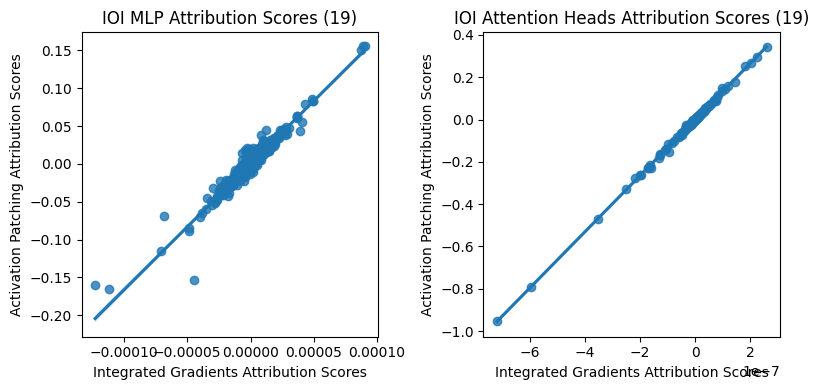

Correlation coefficient for neurons: 0.9815864921395606
Correlation coefficient for attention heads: 0.9994512658915323


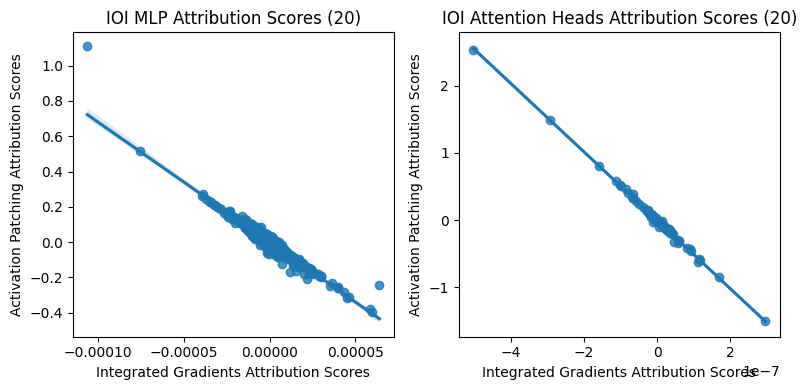

Correlation coefficient for neurons: -0.9837734019141705
Correlation coefficient for attention heads: -0.9987260620810059


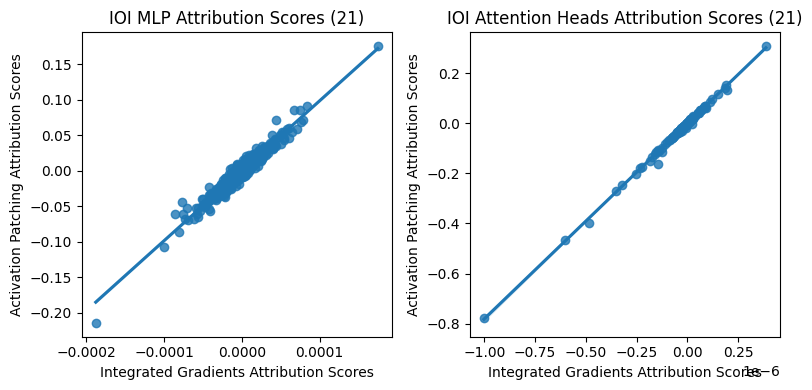

Correlation coefficient for neurons: 0.9840109859970982
Correlation coefficient for attention heads: 0.9983929958877743


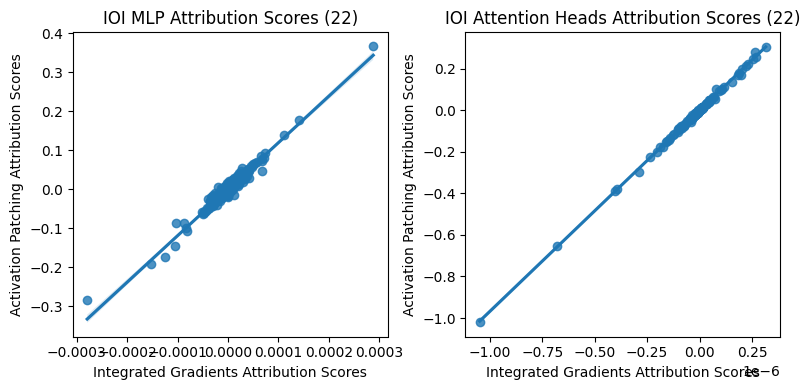

Correlation coefficient for neurons: 0.9819756218408434
Correlation coefficient for attention heads: 0.9992686318916717


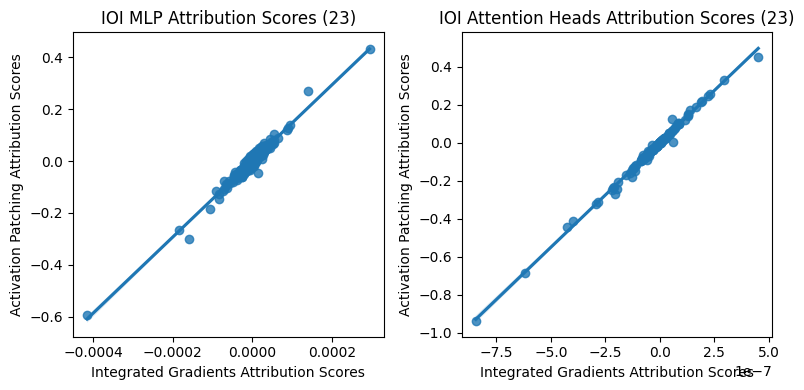

Correlation coefficient for neurons: 0.9835941626835193
Correlation coefficient for attention heads: 0.9968403895952419


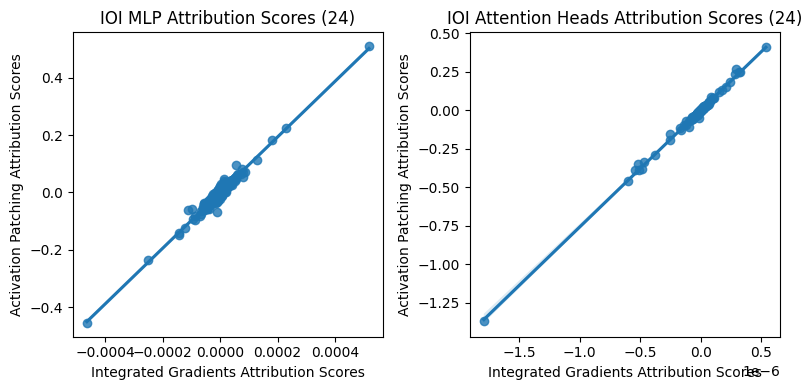

Correlation coefficient for neurons: 0.9849124843743411
Correlation coefficient for attention heads: 0.9982435829666758


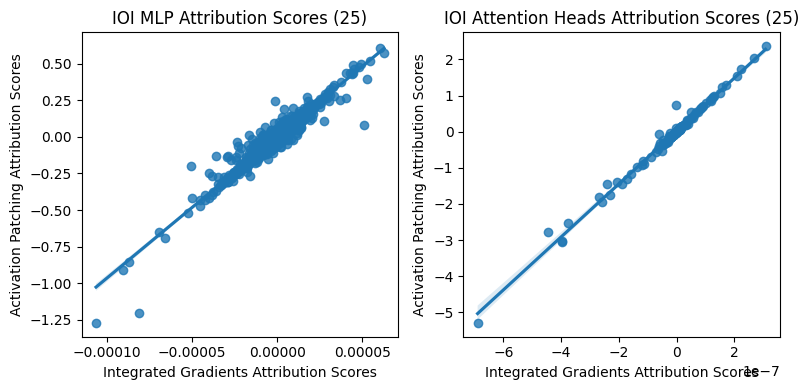

Correlation coefficient for neurons: 0.9762395004791613
Correlation coefficient for attention heads: 0.9936360655534172


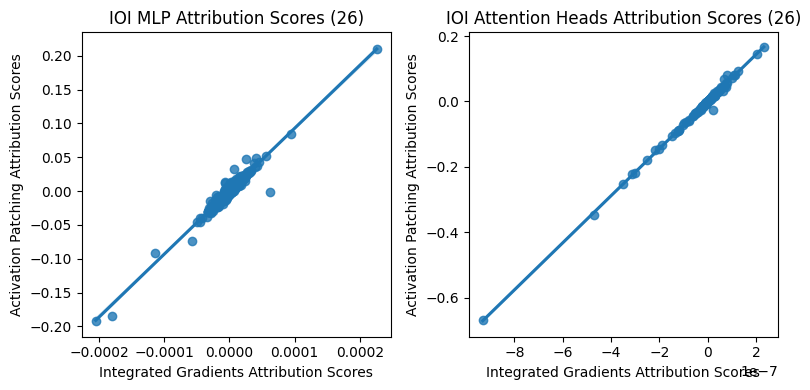

Correlation coefficient for neurons: 0.9832869339517946
Correlation coefficient for attention heads: 0.9982683853160106


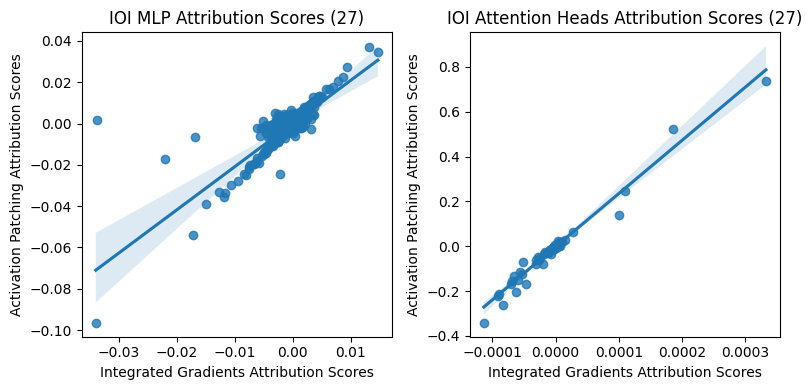

Correlation coefficient for neurons: 0.8553208264502753
Correlation coefficient for attention heads: 0.9852710905629064


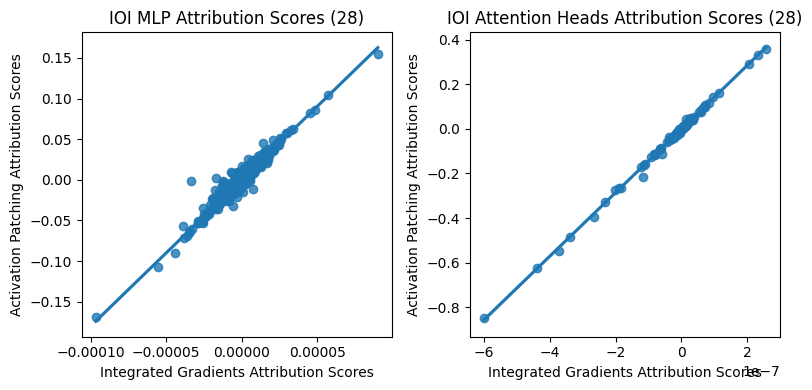

Correlation coefficient for neurons: 0.9830996204846247
Correlation coefficient for attention heads: 0.9988969200505182


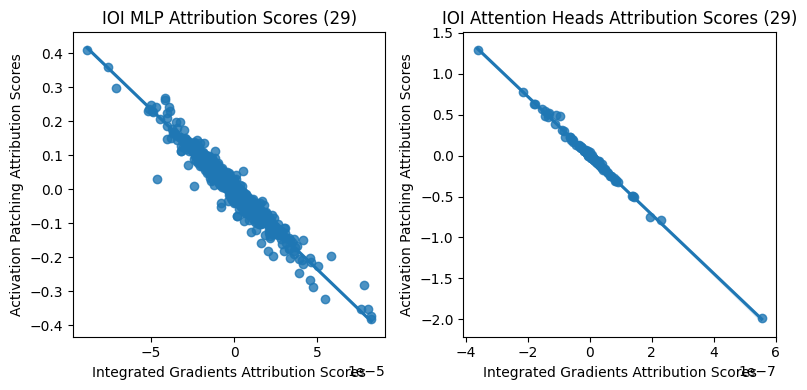

Correlation coefficient for neurons: -0.9814751253861135
Correlation coefficient for attention heads: -0.9976773999597033


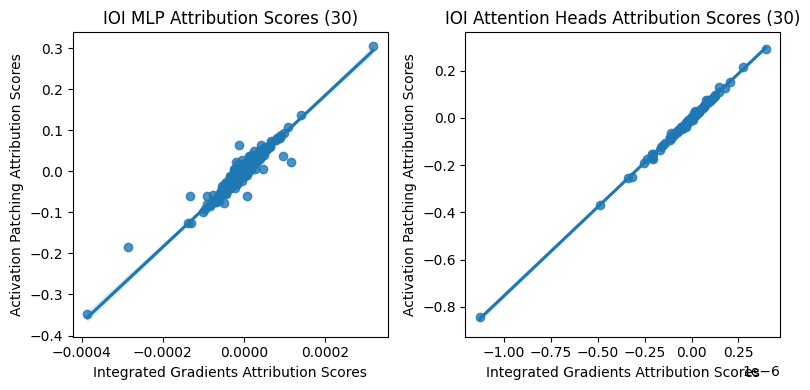

Correlation coefficient for neurons: 0.9721070432741074
Correlation coefficient for attention heads: 0.9988956866204106


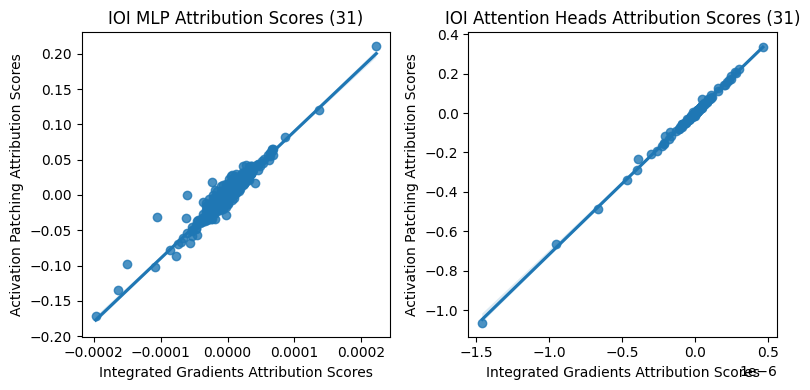

Correlation coefficient for neurons: 0.9704226707095558
Correlation coefficient for attention heads: 0.9984606697059019


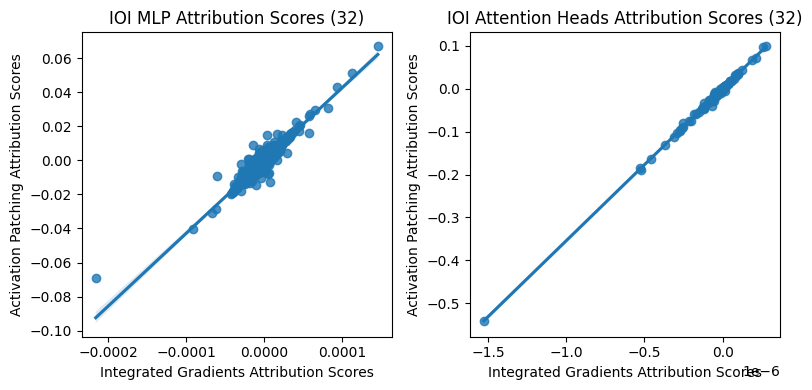

Correlation coefficient for neurons: 0.9669362020374435
Correlation coefficient for attention heads: 0.9987982873469163


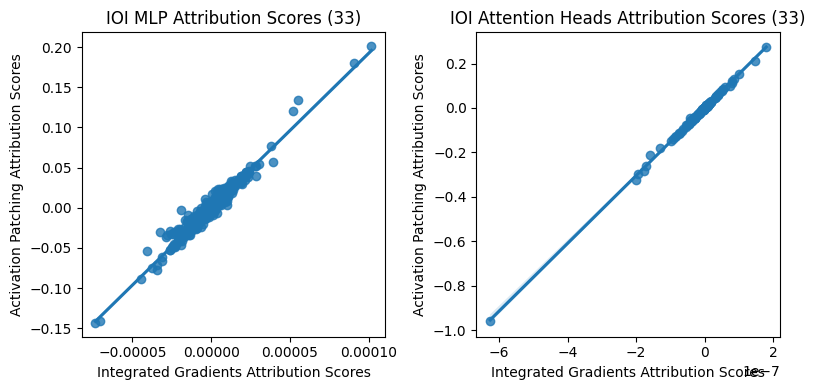

Correlation coefficient for neurons: 0.9869257539374623
Correlation coefficient for attention heads: 0.9990773871661772


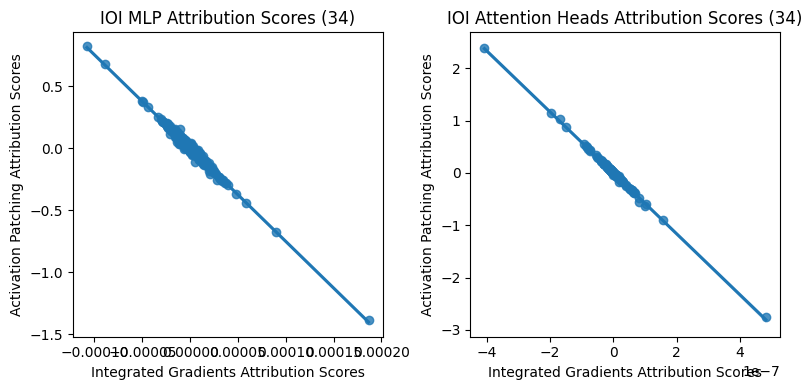

Correlation coefficient for neurons: -0.9944564121760757
Correlation coefficient for attention heads: -0.9994165576547042


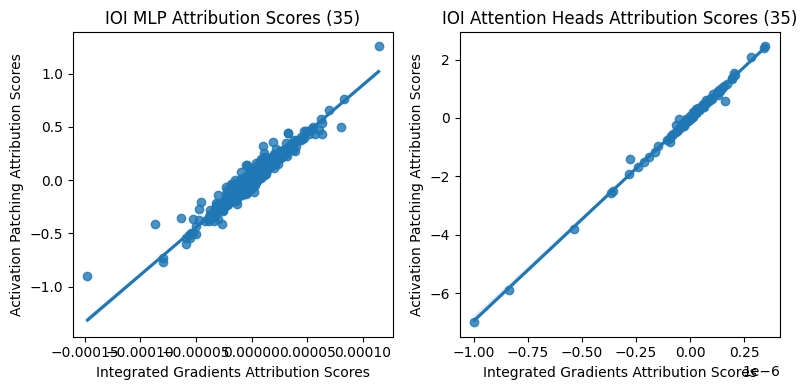

Correlation coefficient for neurons: 0.9822816011097273
Correlation coefficient for attention heads: 0.9973660207176773


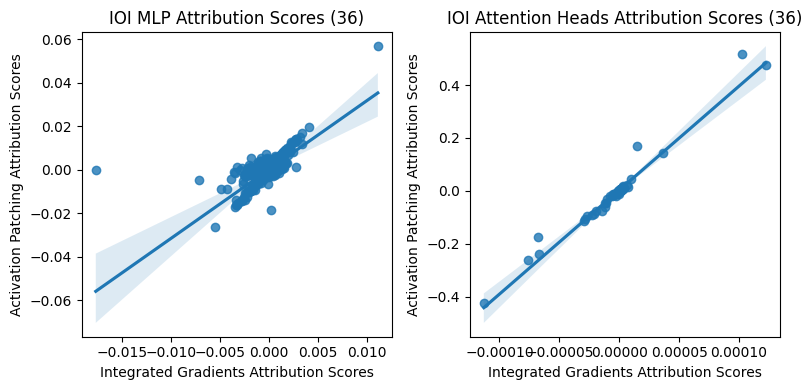

Correlation coefficient for neurons: 0.7900300987903942
Correlation coefficient for attention heads: 0.9804777653863905


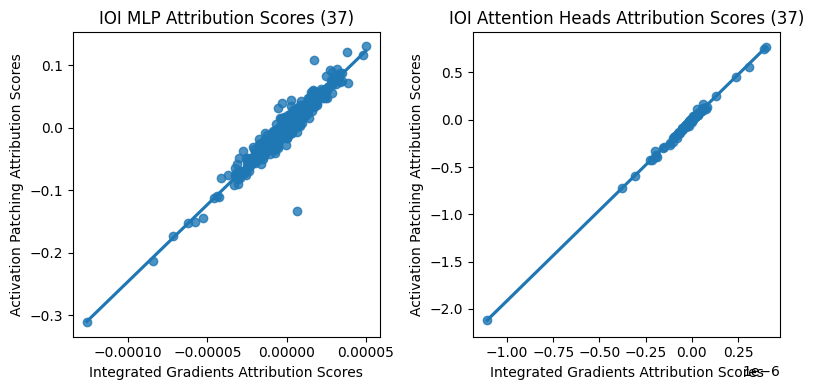

Correlation coefficient for neurons: 0.9827591673915153
Correlation coefficient for attention heads: 0.9986498623797959


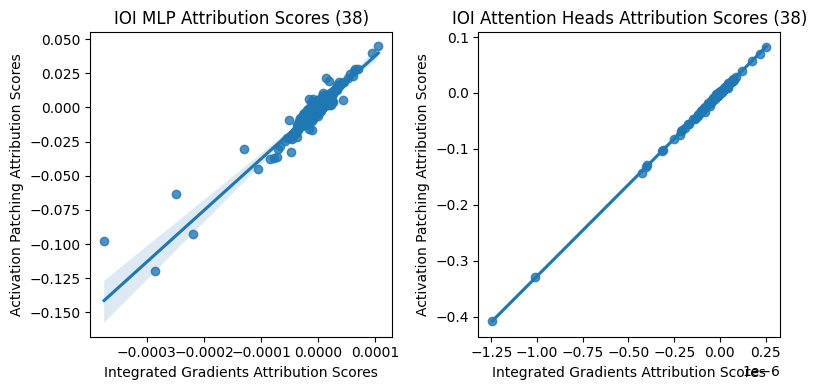

Correlation coefficient for neurons: 0.9624271648055462
Correlation coefficient for attention heads: 0.9996765385706157


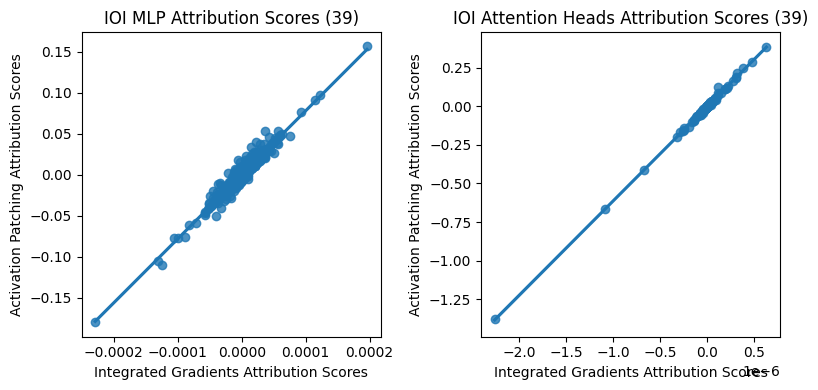

Correlation coefficient for neurons: 0.9800822074962369
Correlation coefficient for attention heads: 0.9992304181011556


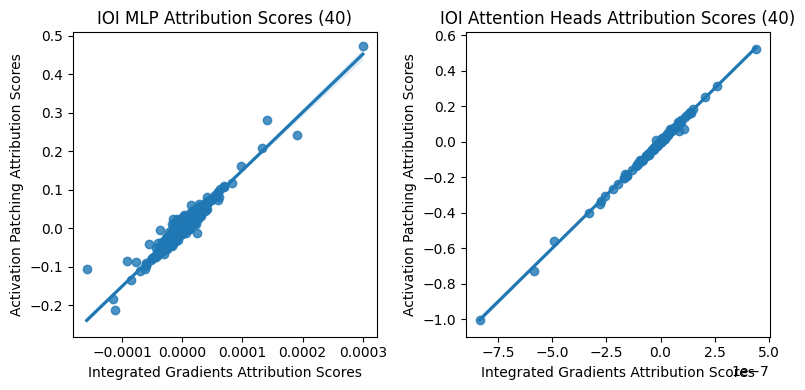

Correlation coefficient for neurons: 0.9800727625070675
Correlation coefficient for attention heads: 0.9985761067780642


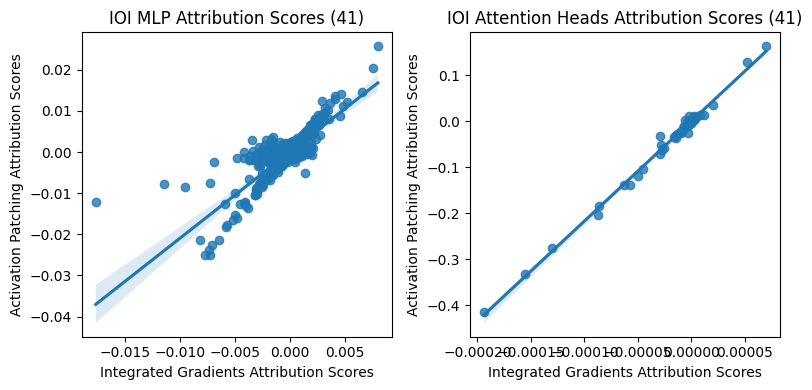

Correlation coefficient for neurons: 0.8497741862897302
Correlation coefficient for attention heads: 0.9965967306304613


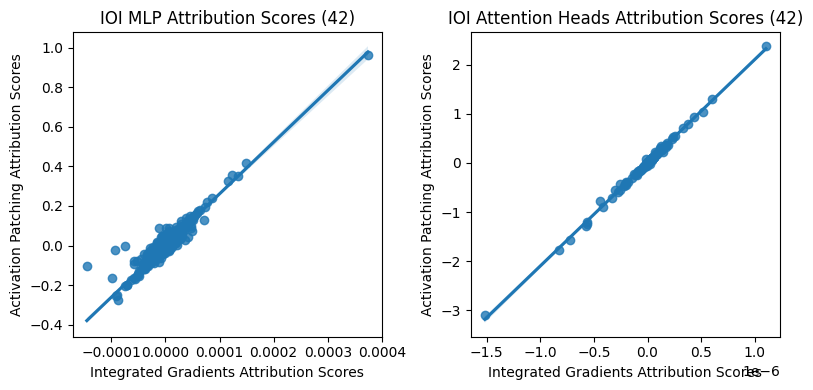

Correlation coefficient for neurons: 0.9699914822584399
Correlation coefficient for attention heads: 0.9982879705421387


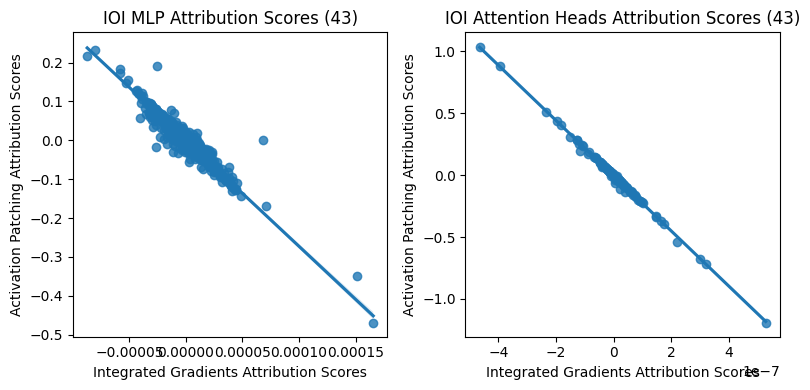

Correlation coefficient for neurons: -0.9775852979484254
Correlation coefficient for attention heads: -0.9985754529733635


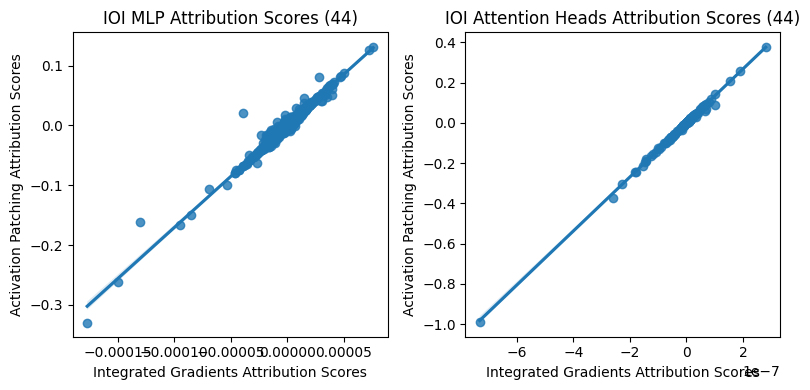

Correlation coefficient for neurons: 0.9885409184783548
Correlation coefficient for attention heads: 0.9985566054608607


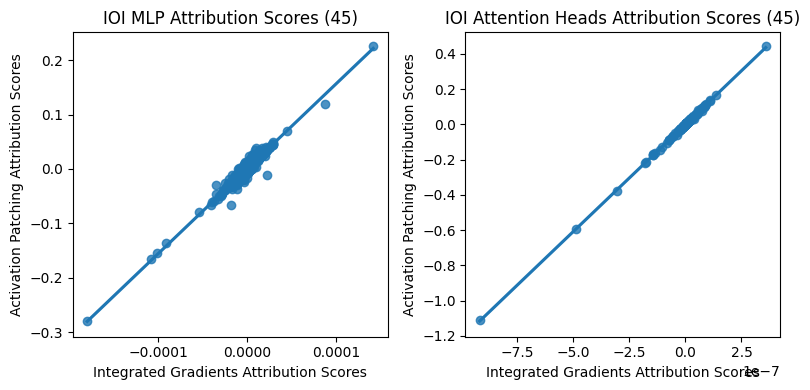

Correlation coefficient for neurons: 0.9832868946022286
Correlation coefficient for attention heads: 0.999689811141332


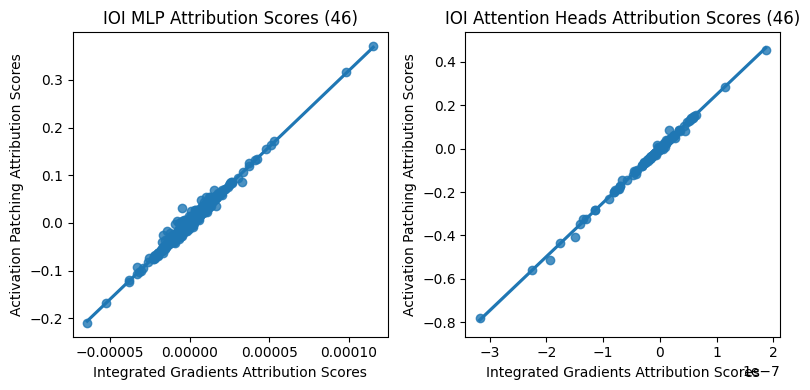

Correlation coefficient for neurons: 0.99300660734126
Correlation coefficient for attention heads: 0.9984653816709564


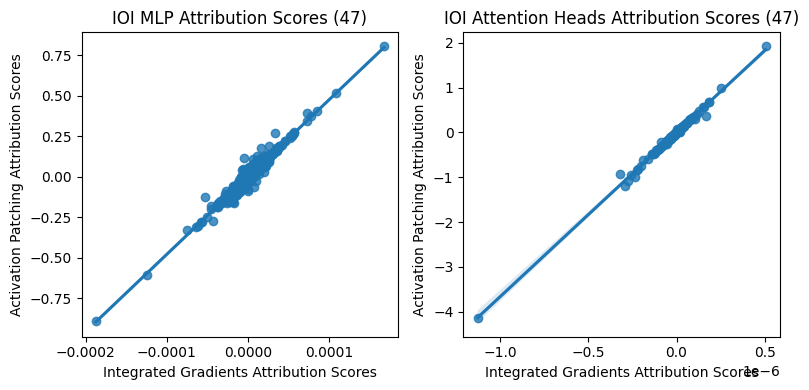

Correlation coefficient for neurons: 0.9856011486731909
Correlation coefficient for attention heads: 0.9969070440481366


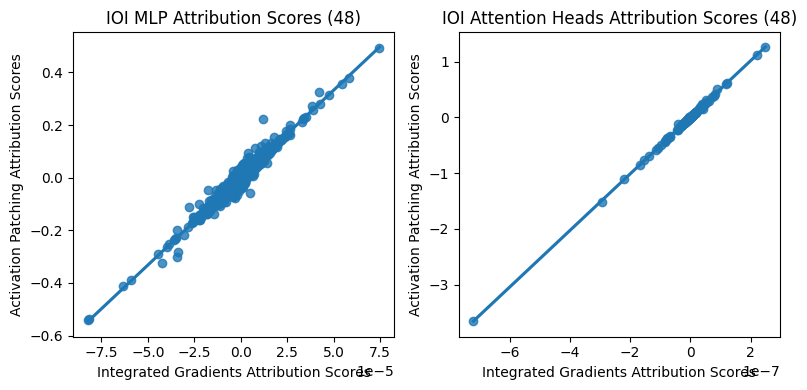

Correlation coefficient for neurons: 0.9885112932993794
Correlation coefficient for attention heads: 0.999613342698759


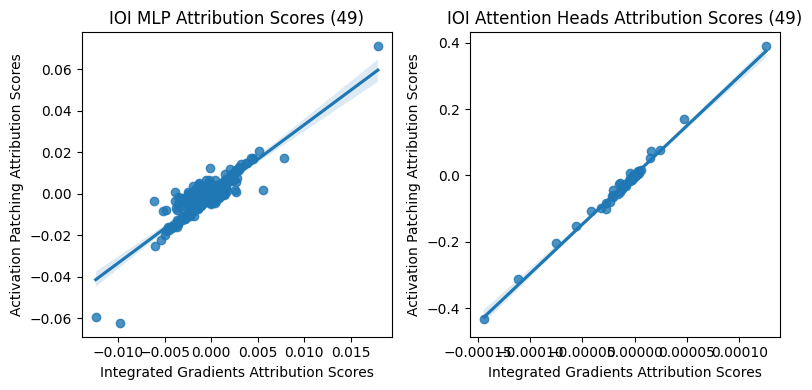

Correlation coefficient for neurons: 0.8912397387391499
Correlation coefficient for attention heads: 0.9951610440481427


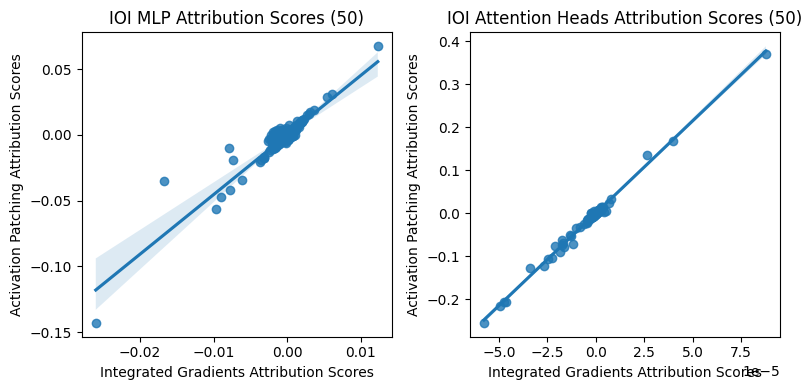

Correlation coefficient for neurons: 0.9312970204787703
Correlation coefficient for attention heads: 0.9963498250296466


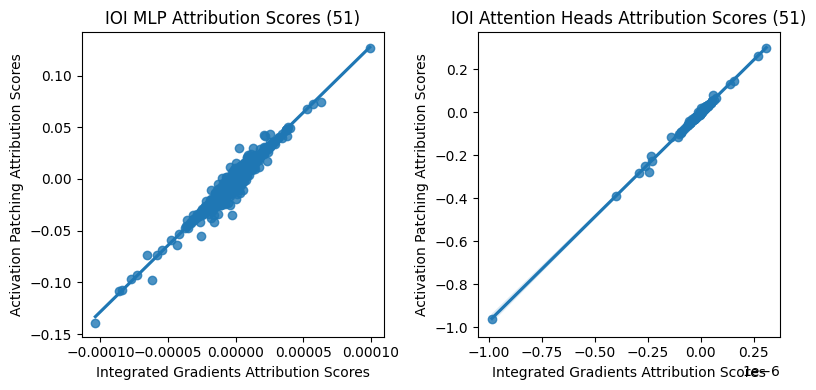

Correlation coefficient for neurons: 0.984764260632334
Correlation coefficient for attention heads: 0.9985220595430421


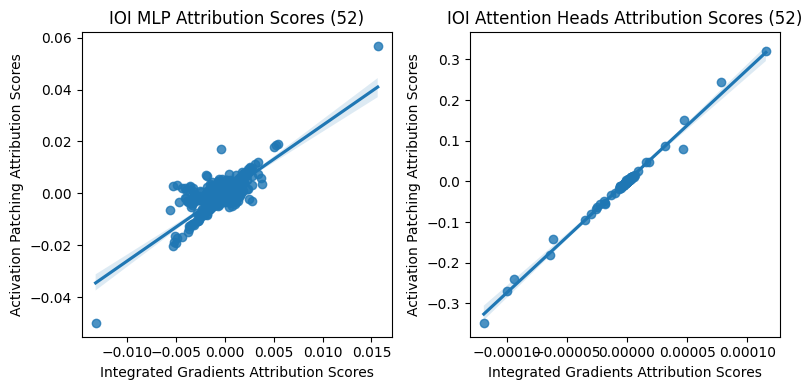

Correlation coefficient for neurons: 0.834868856017671
Correlation coefficient for attention heads: 0.9948244546384108


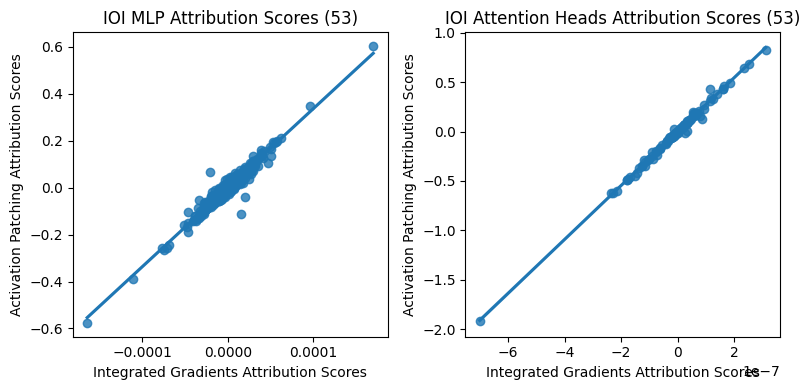

Correlation coefficient for neurons: 0.9818805786735164
Correlation coefficient for attention heads: 0.9969888875686479


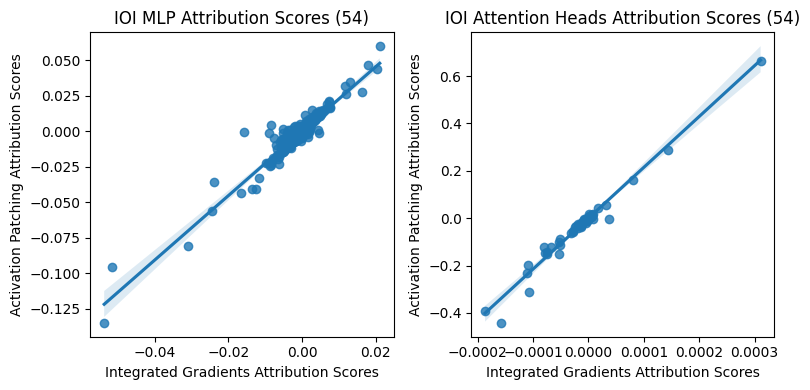

Correlation coefficient for neurons: 0.952257069116516
Correlation coefficient for attention heads: 0.9861257047594753


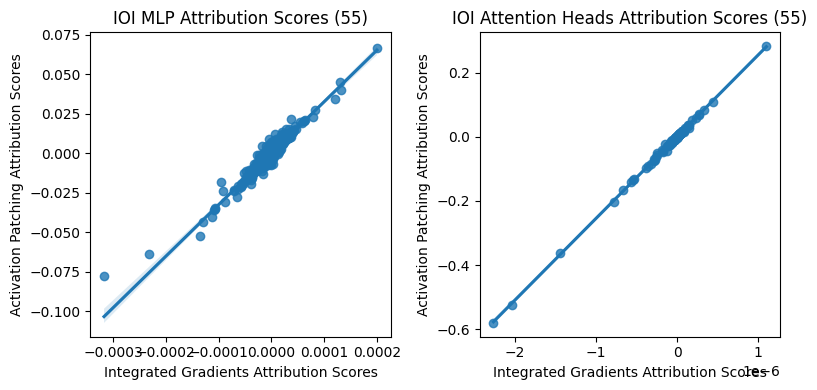

Correlation coefficient for neurons: 0.9757925118167866
Correlation coefficient for attention heads: 0.999467353611148


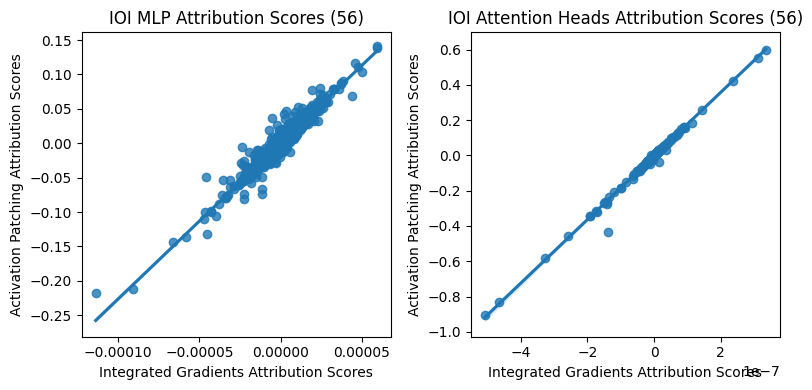

Correlation coefficient for neurons: 0.9799083984407423
Correlation coefficient for attention heads: 0.9951525930574169


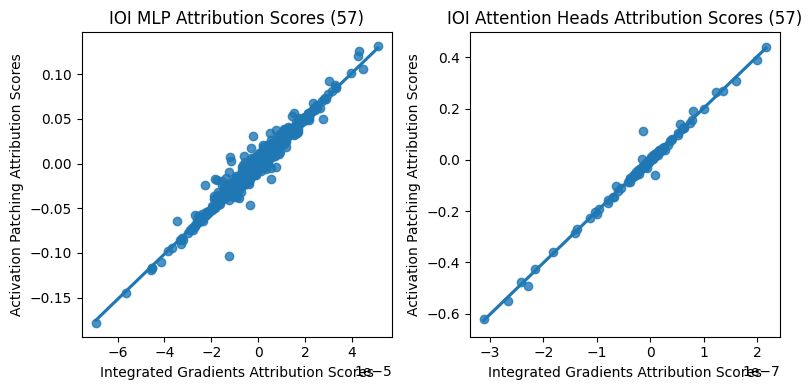

Correlation coefficient for neurons: 0.9883024395246789
Correlation coefficient for attention heads: 0.9941514806749046


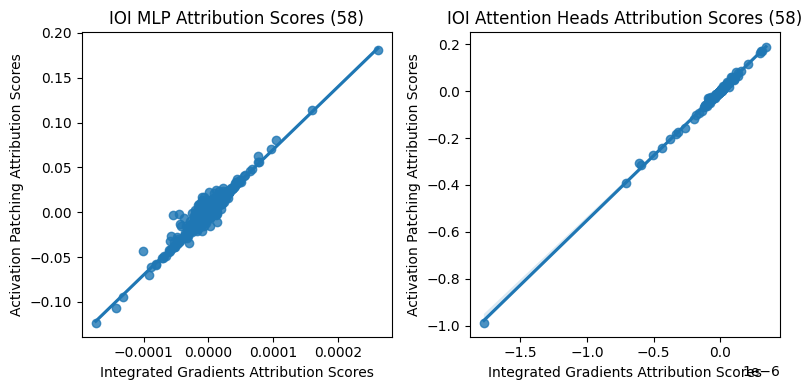

Correlation coefficient for neurons: 0.9737473450768205
Correlation coefficient for attention heads: 0.9987499821032102


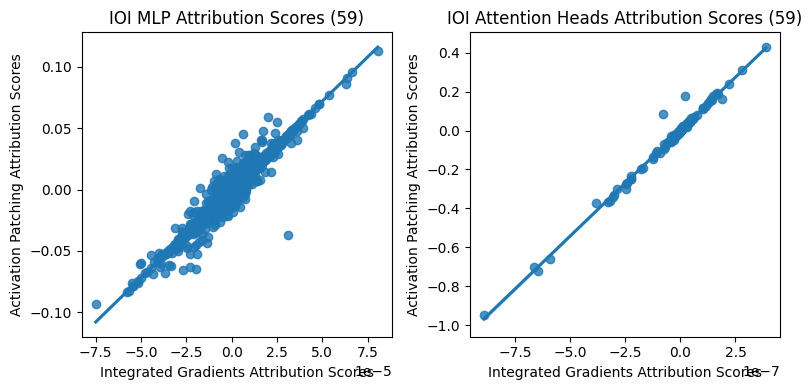

Correlation coefficient for neurons: 0.981146554566979
Correlation coefficient for attention heads: 0.9925629899572503


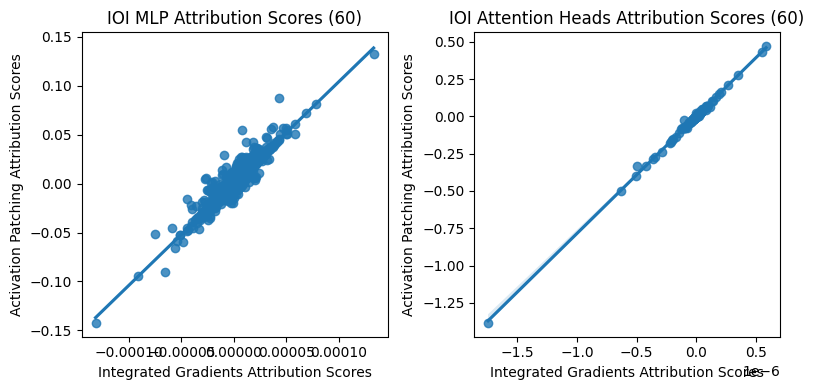

Correlation coefficient for neurons: 0.9666460793491611
Correlation coefficient for attention heads: 0.998654575932806


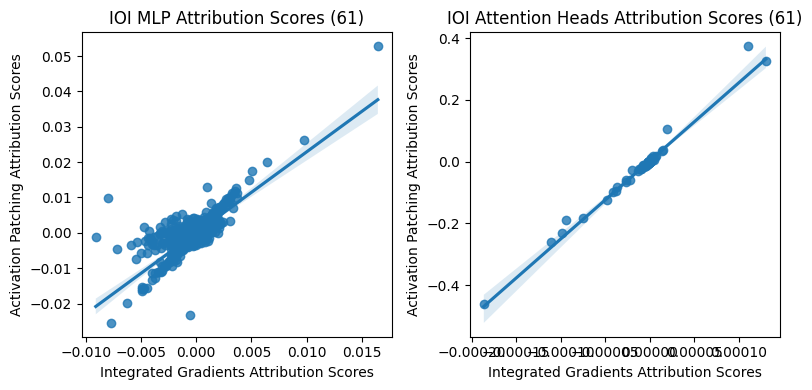

Correlation coefficient for neurons: 0.8287549288313687
Correlation coefficient for attention heads: 0.9888315311939964


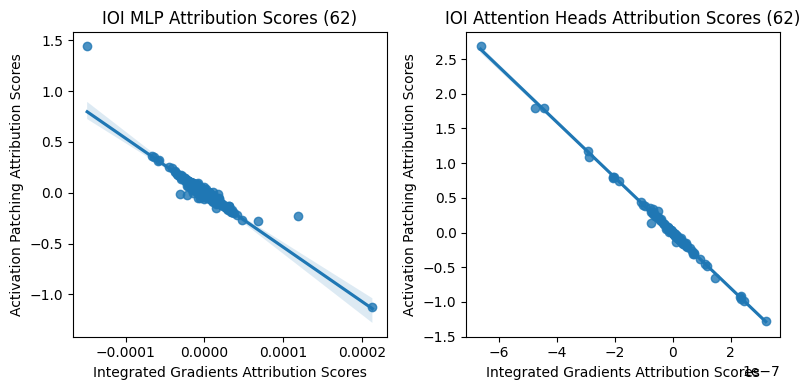

Correlation coefficient for neurons: -0.9624756987077078
Correlation coefficient for attention heads: -0.9983172029271423


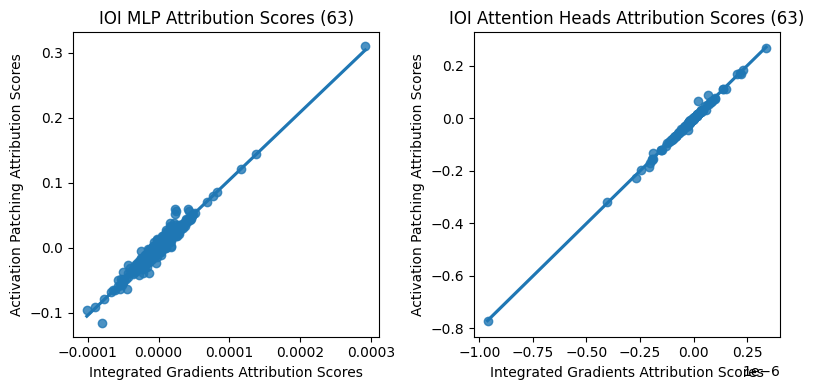

Correlation coefficient for neurons: 0.9851675766013631
Correlation coefficient for attention heads: 0.9978203953645977


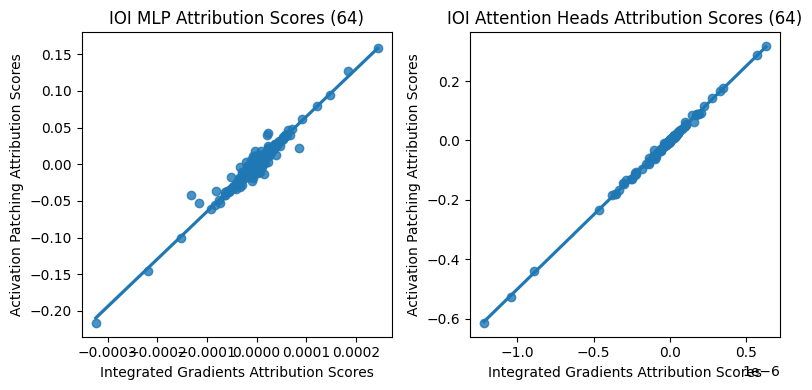

Correlation coefficient for neurons: 0.9811672207127046
Correlation coefficient for attention heads: 0.9991751960780161


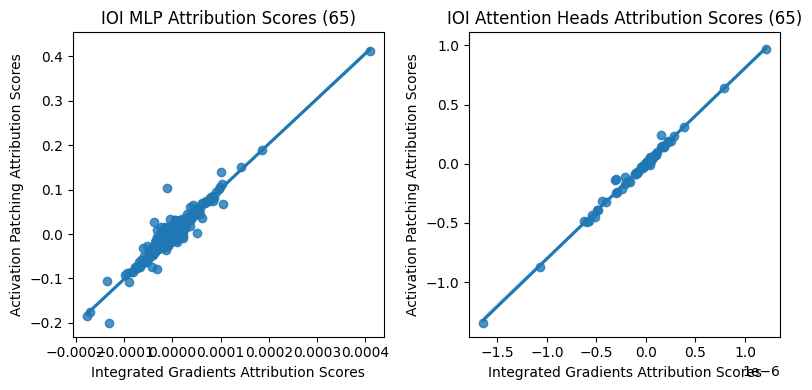

Correlation coefficient for neurons: 0.9725970857288917
Correlation coefficient for attention heads: 0.995660194067745


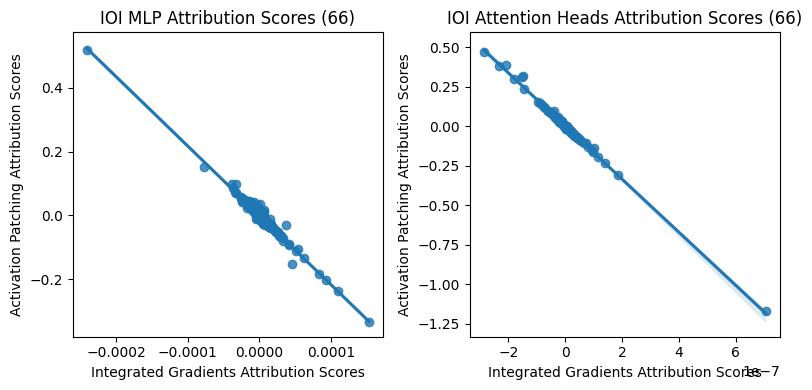

Correlation coefficient for neurons: -0.9899008722905496
Correlation coefficient for attention heads: -0.9975344835956761


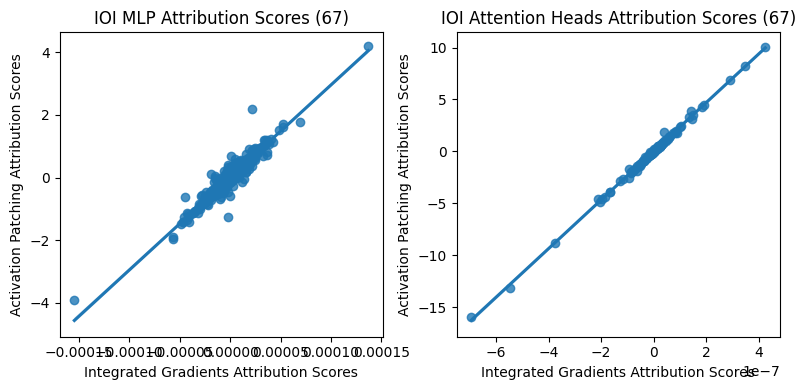

Correlation coefficient for neurons: 0.9763938509388548
Correlation coefficient for attention heads: 0.9986906478986085


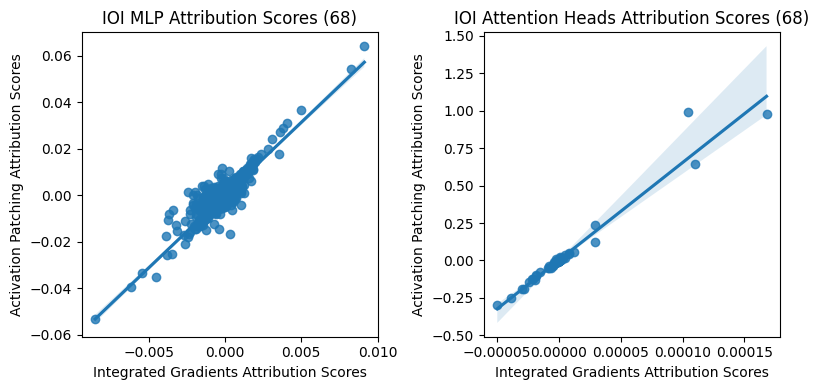

Correlation coefficient for neurons: 0.9209156242055977
Correlation coefficient for attention heads: 0.9769375670229782


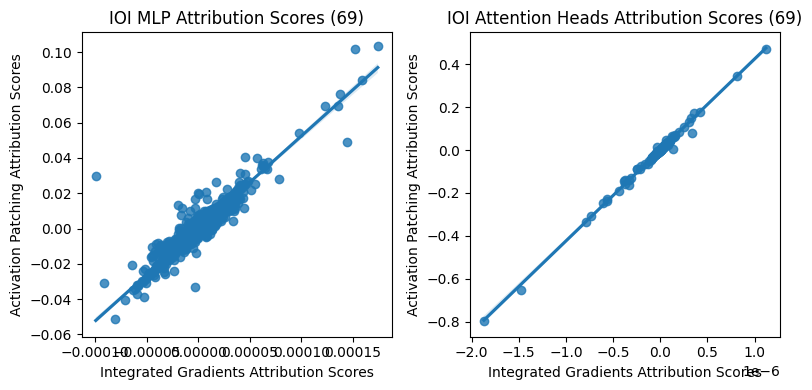

Correlation coefficient for neurons: 0.9643941214268487
Correlation coefficient for attention heads: 0.9972645316864361


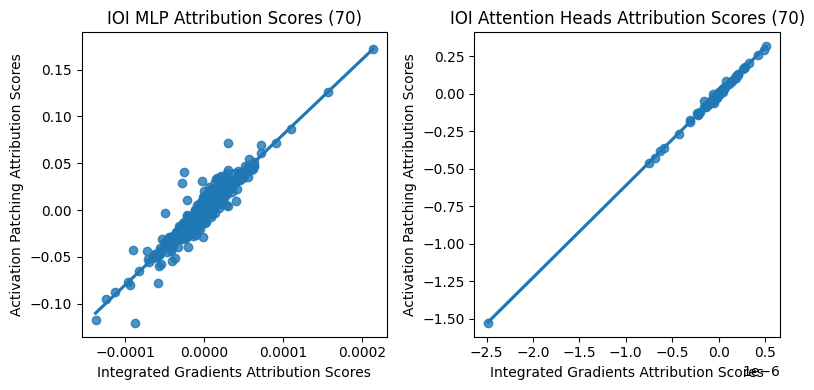

Correlation coefficient for neurons: 0.9690165980575883
Correlation coefficient for attention heads: 0.9989856819961037


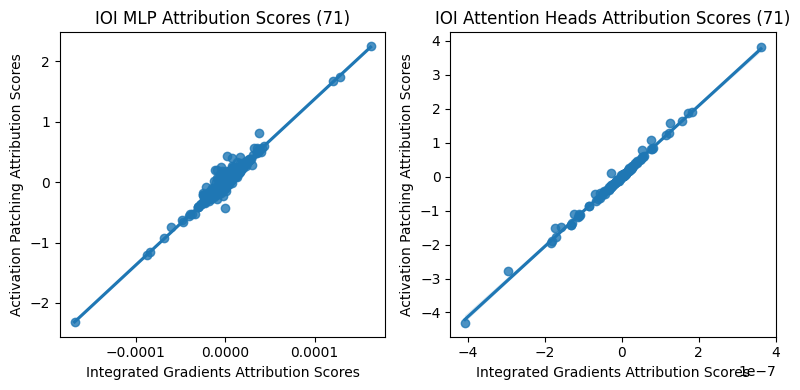

Correlation coefficient for neurons: 0.9835593501858041
Correlation coefficient for attention heads: 0.9964944633813856


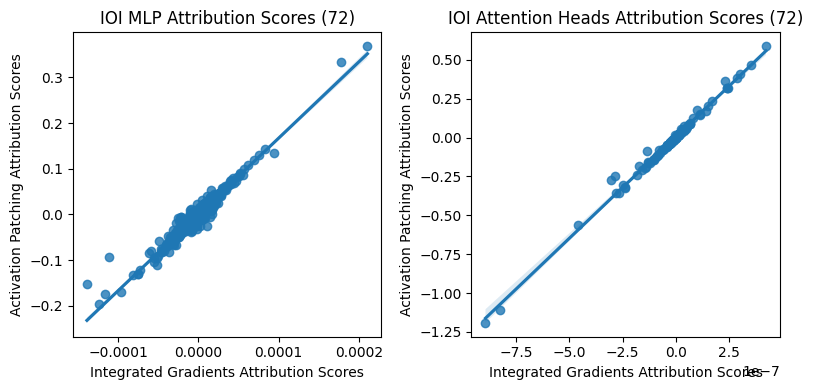

Correlation coefficient for neurons: 0.9823609883054044
Correlation coefficient for attention heads: 0.9952955790915243


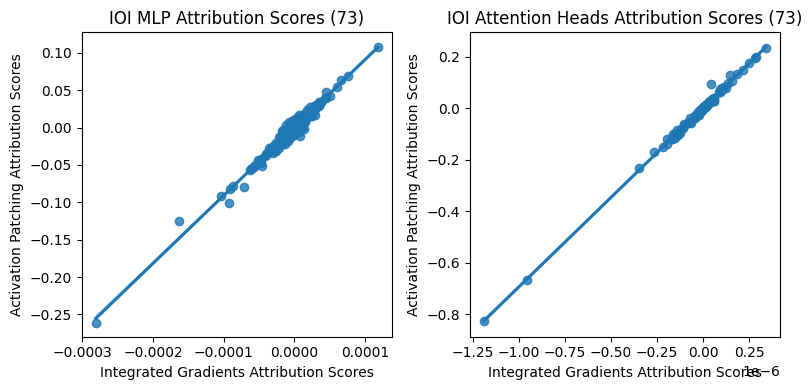

Correlation coefficient for neurons: 0.9865035731360393
Correlation coefficient for attention heads: 0.9978557464639998


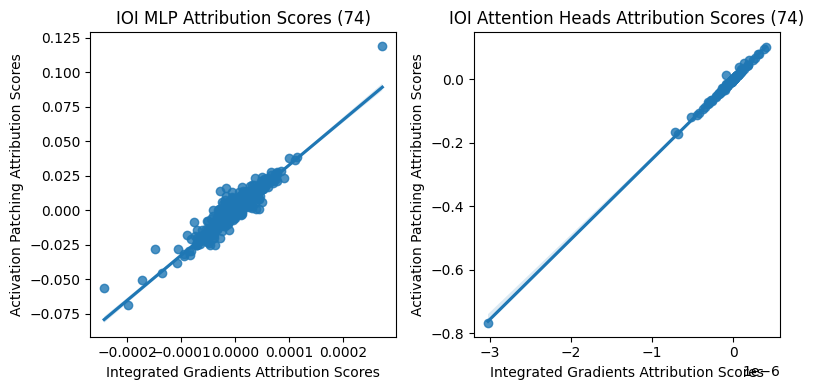

Correlation coefficient for neurons: 0.9681122524404054
Correlation coefficient for attention heads: 0.9981946312999685


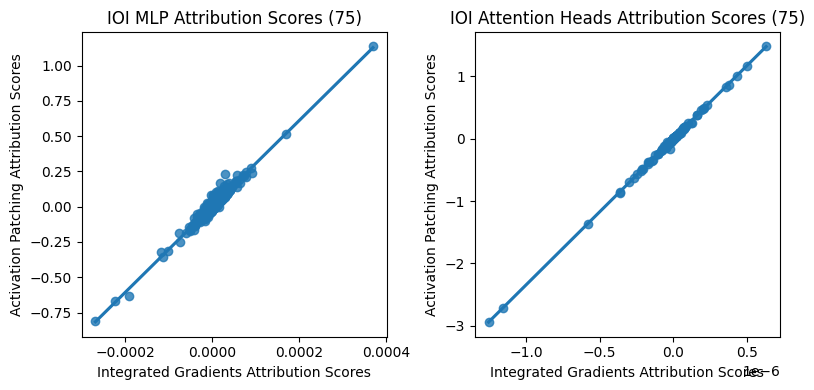

Correlation coefficient for neurons: 0.9836545033989639
Correlation coefficient for attention heads: 0.999533932913904


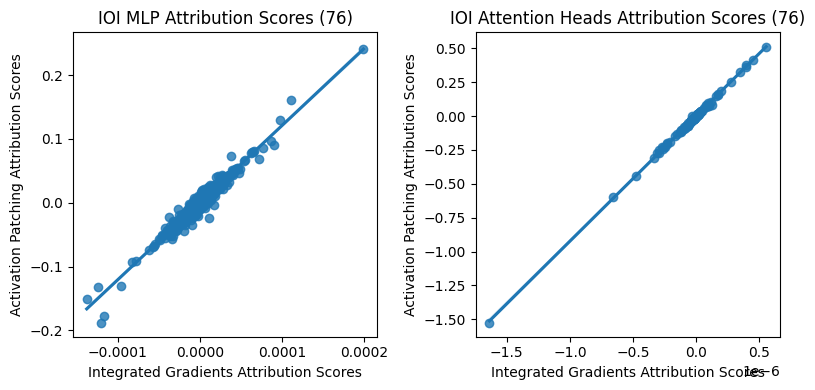

Correlation coefficient for neurons: 0.9831358818350554
Correlation coefficient for attention heads: 0.9993801386955561


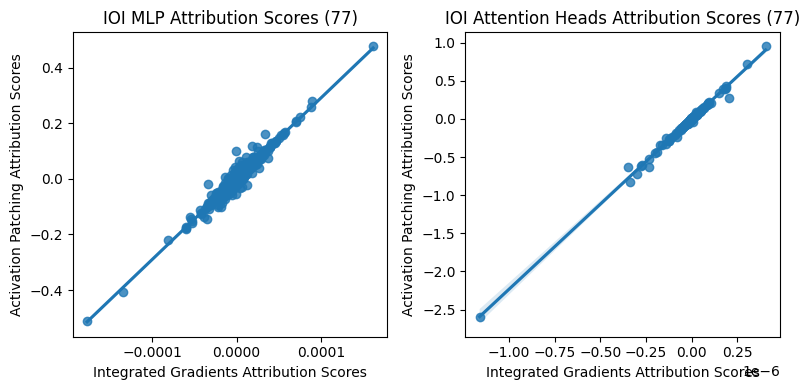

Correlation coefficient for neurons: 0.9840739579331144
Correlation coefficient for attention heads: 0.9964068221744486


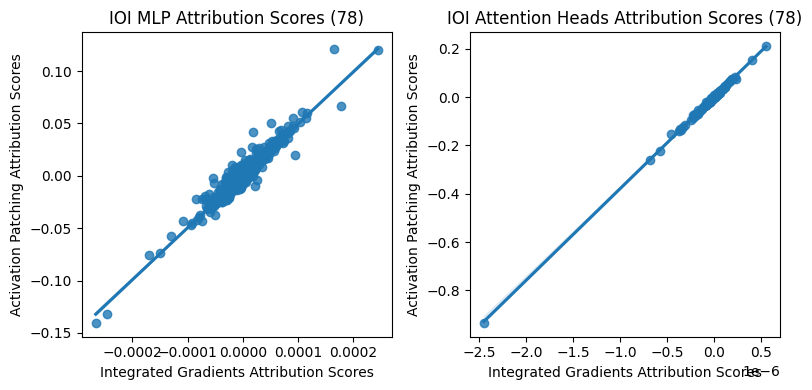

Correlation coefficient for neurons: 0.9756935108517024
Correlation coefficient for attention heads: 0.9993465186616378


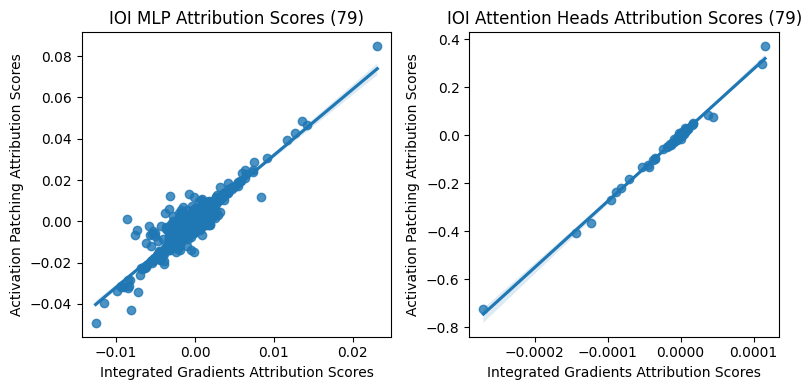

Correlation coefficient for neurons: 0.9253823928632442
Correlation coefficient for attention heads: 0.9968561237108304


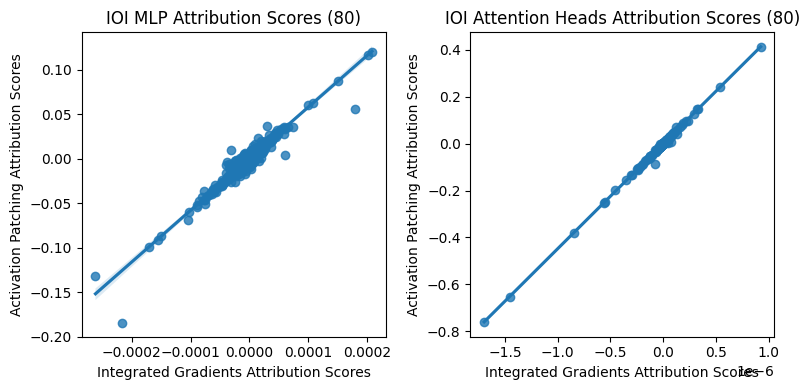

Correlation coefficient for neurons: 0.9770202171622772
Correlation coefficient for attention heads: 0.9987057206074776


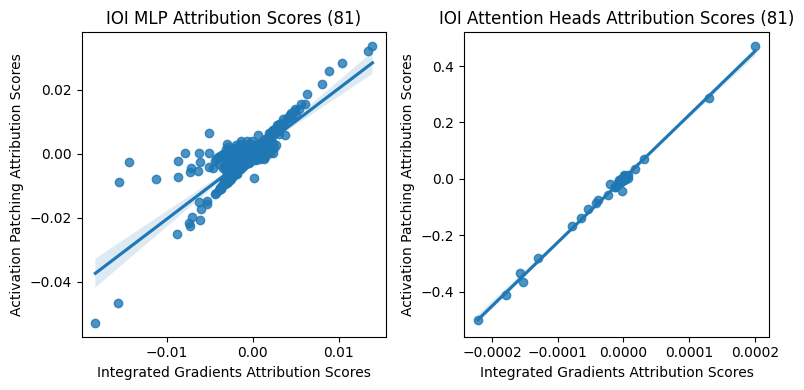

Correlation coefficient for neurons: 0.8651151052956753
Correlation coefficient for attention heads: 0.9977622528217943


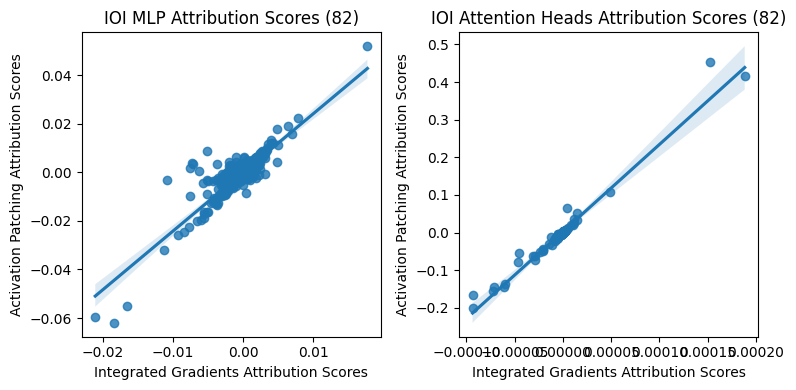

Correlation coefficient for neurons: 0.8922186737106034
Correlation coefficient for attention heads: 0.9831049713807715


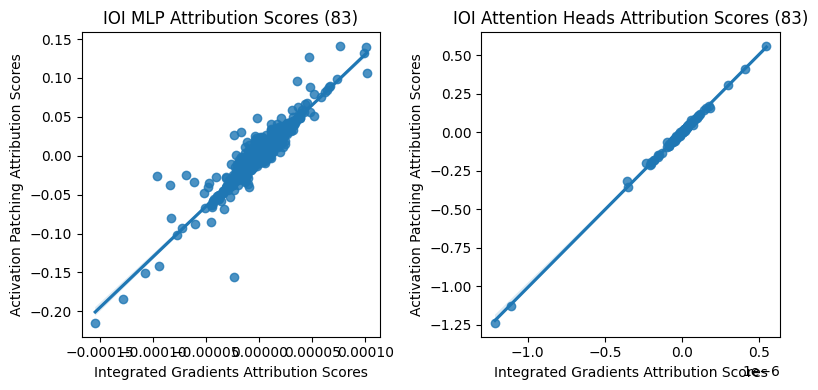

Correlation coefficient for neurons: 0.9600521040144987
Correlation coefficient for attention heads: 0.999005469056502


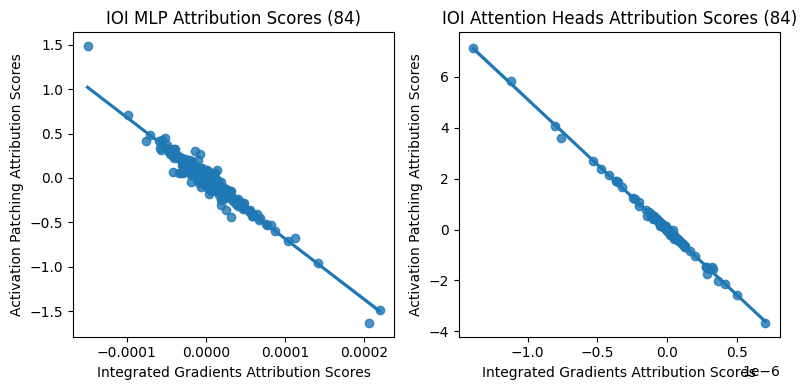

Correlation coefficient for neurons: -0.983398499944008
Correlation coefficient for attention heads: -0.9989211372074948


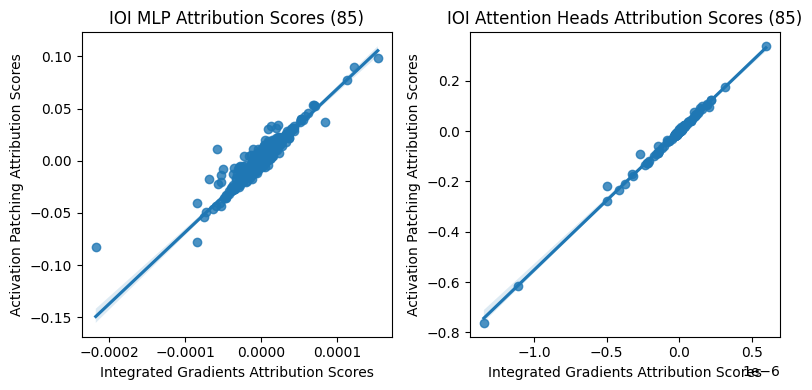

Correlation coefficient for neurons: 0.9659040980706384
Correlation coefficient for attention heads: 0.9972551979023001


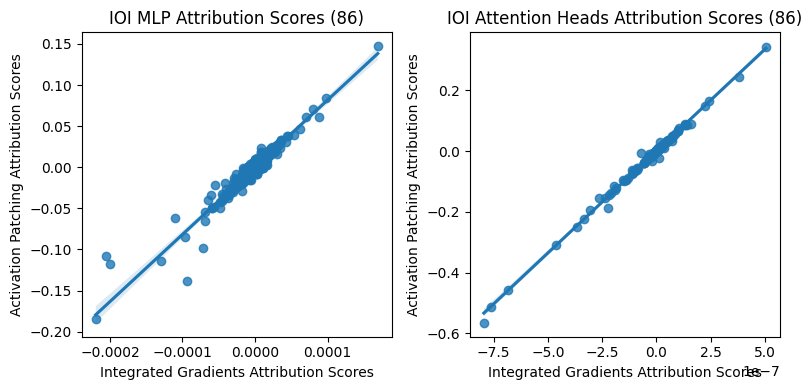

Correlation coefficient for neurons: 0.972808352047216
Correlation coefficient for attention heads: 0.9974388685852146


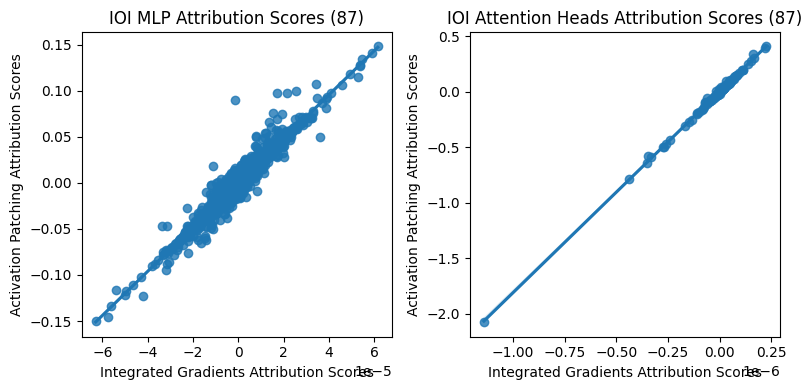

Correlation coefficient for neurons: 0.9834607279870533
Correlation coefficient for attention heads: 0.9988723954801497


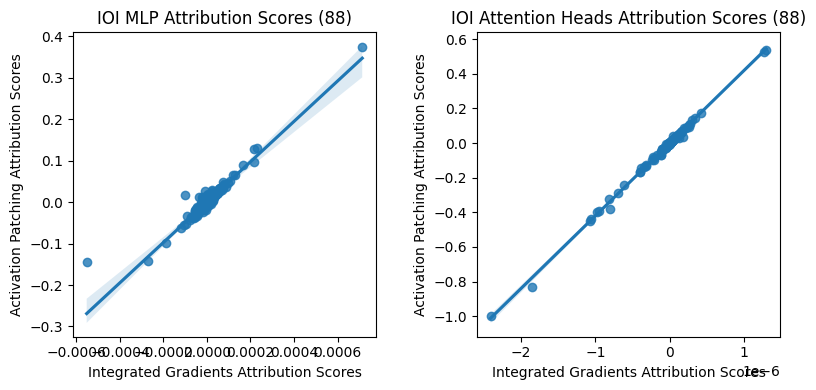

Correlation coefficient for neurons: 0.9644125413058097
Correlation coefficient for attention heads: 0.9985281272497328


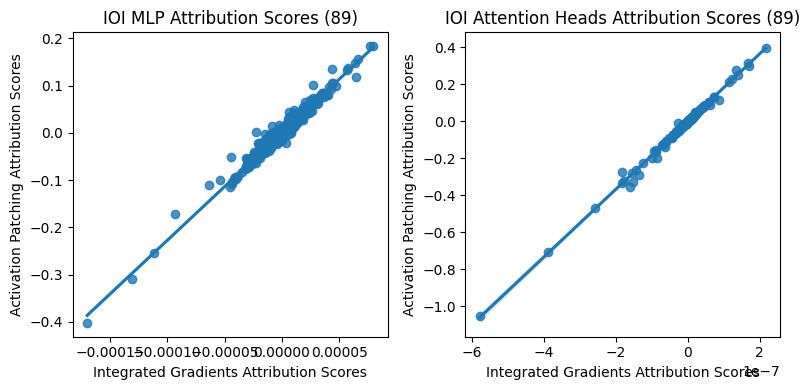

Correlation coefficient for neurons: 0.9880847793260634
Correlation coefficient for attention heads: 0.9972395042699174


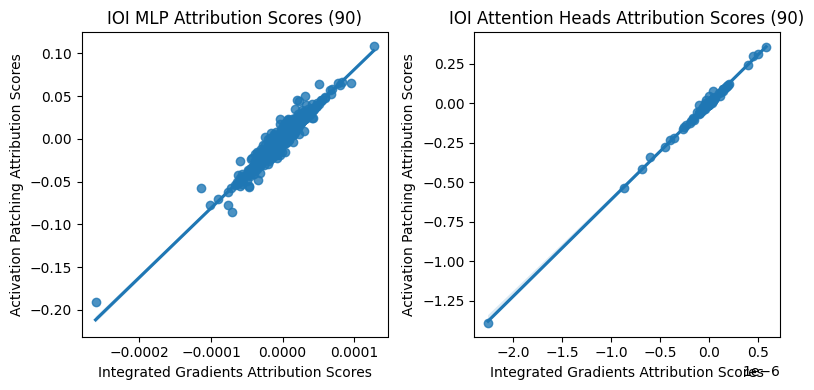

Correlation coefficient for neurons: 0.9780099585005648
Correlation coefficient for attention heads: 0.9977496006644618


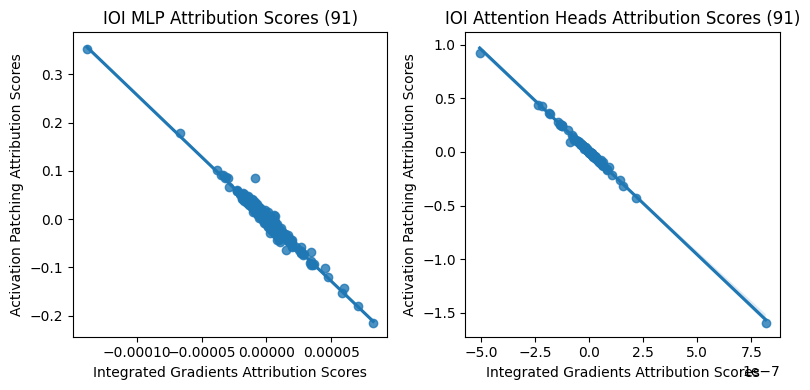

Correlation coefficient for neurons: -0.9899399490628407
Correlation coefficient for attention heads: -0.9984657894511544


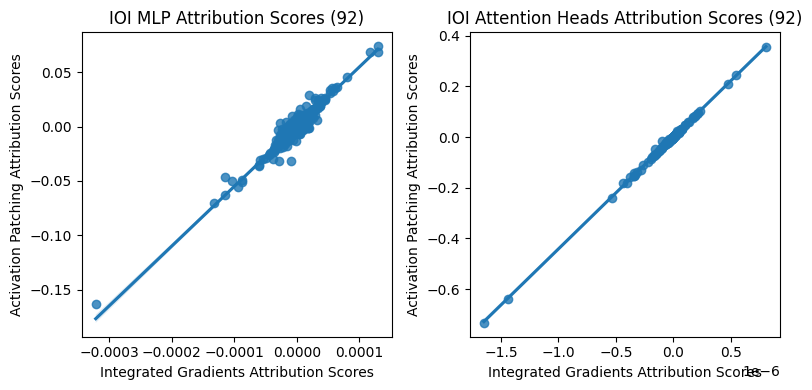

Correlation coefficient for neurons: 0.9765415225772411
Correlation coefficient for attention heads: 0.9992594035906035


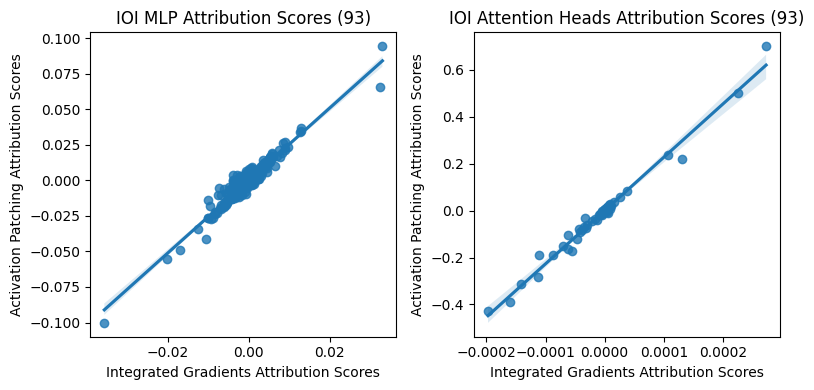

Correlation coefficient for neurons: 0.955134571668647
Correlation coefficient for attention heads: 0.9911285856264468


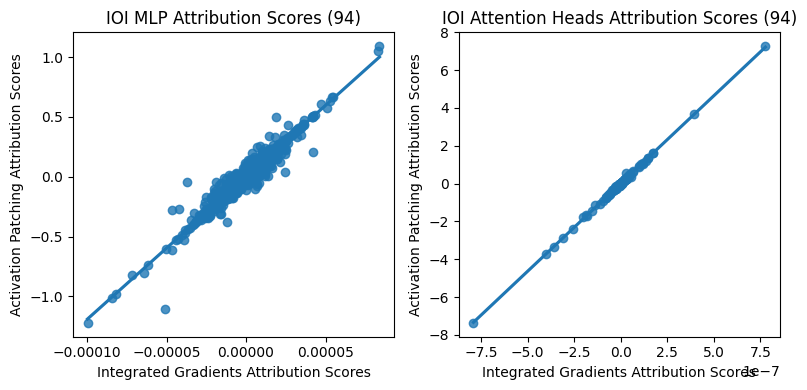

Correlation coefficient for neurons: 0.9814009629535804
Correlation coefficient for attention heads: 0.9993810363935394


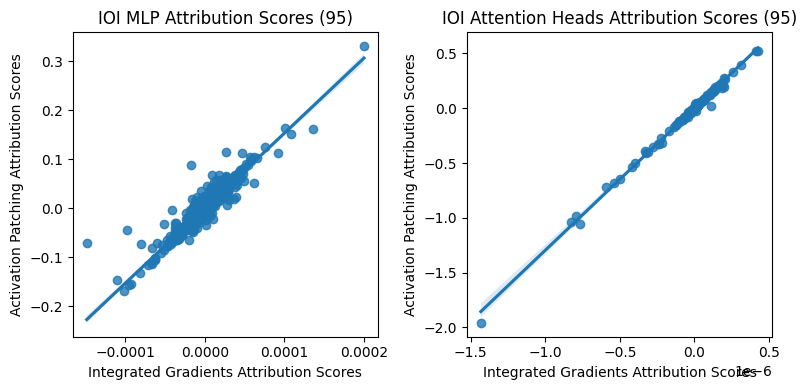

Correlation coefficient for neurons: 0.9640045229753686
Correlation coefficient for attention heads: 0.9974969082112035


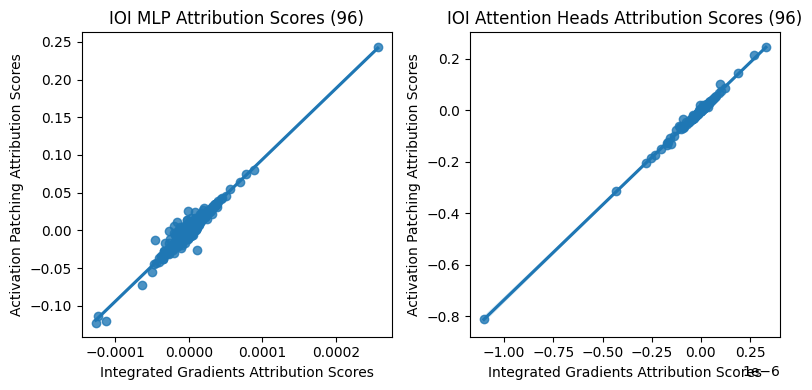

Correlation coefficient for neurons: 0.9802984686883421
Correlation coefficient for attention heads: 0.9978528724953799


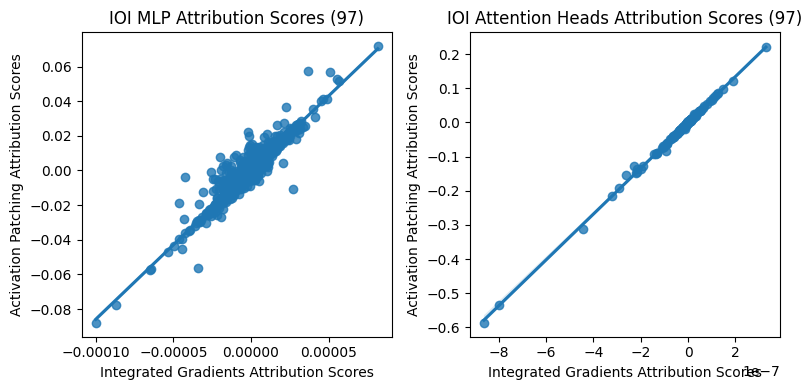

Correlation coefficient for neurons: 0.9651590521538347
Correlation coefficient for attention heads: 0.9989774435697983


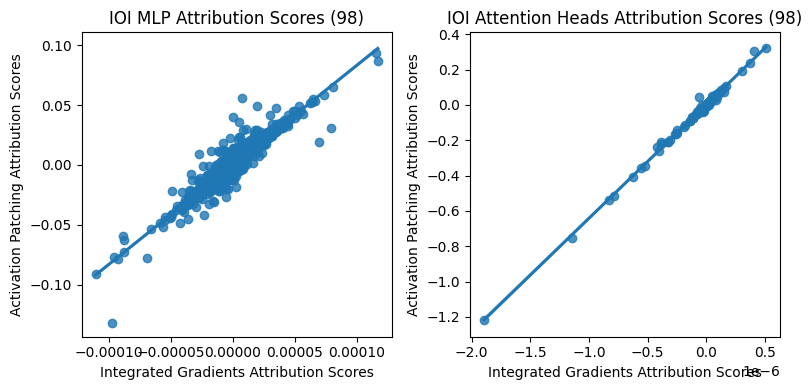

Correlation coefficient for neurons: 0.9657314394101468
Correlation coefficient for attention heads: 0.9978229610602214


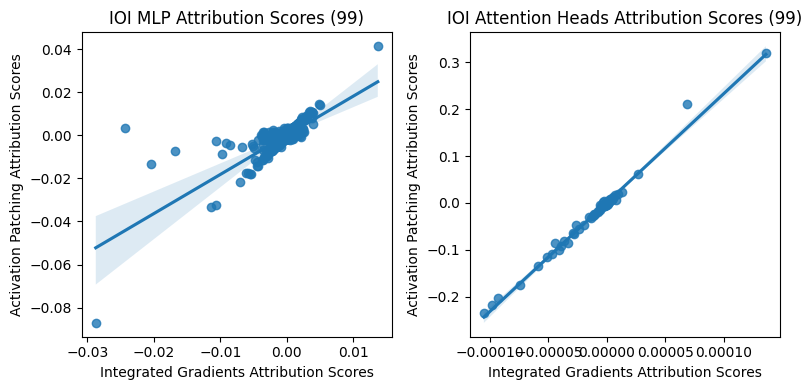

Correlation coefficient for neurons: 0.7944125251790505
Correlation coefficient for attention heads: 0.9948419438443573
Average absolute correlation between IG and AP neurons for IOI: 0.9589831382542942
Average absolute correlation between IG and AP attention heads for IOI: 0.9960553561898219


In [7]:
plot_correlation_comparison(ioi_ig_mlp, ioi_ap_mlp, ioi_ig_attn, ioi_ap_attn, Task.IOI)

print(f"Average absolute correlation between IG and AP neurons for IOI: {average_correlation(ioi_ig_mlp, ioi_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for IOI: {average_correlation(ioi_ig_attn, ioi_ap_attn)}")

## Greater-Than

### Experiment

In [ ]:
greater_than_dataset = TaskDataset(Task.GENDER_BIAS)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
greater_than_ig_mlp, greater_than_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ig_mlp, "results/aligned/greater_than/ig_mlp.pt")
torch.save(greater_than_ig_attn, "results/aligned/greater_than/ig_attn.pt")

In [ ]:
greater_than_ap_mlp, greater_than_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ap_mlp, "results/aligned/greater_than/ap_mlp.pt")
torch.save(greater_than_ap_attn, "results/aligned/greater_than/ap_attn.pt")

### Analysis

In [ ]:
greater_than_ig_mlp = torch.load("results/aligned/greater_than/ig_mlp.pt")
greater_than_ig_attn = torch.load("results/aligned/greater_than/ig_attn.pt")
greater_than_ap_mlp = torch.load("results/aligned/greater_than/ap_mlp.pt")
greater_than_ap_attn = torch.load("results/aligned/greater_than/ap_attn.pt")

In [ ]:
plot_correlation_comparison(greater_than_ig_mlp, greater_than_ap_mlp, greater_than_ig_attn, greater_than_ap_attn, Task.GREATER_THAN)

print(f"Average absolute correlation between IG and AP neurons for Greater-Than: {average_correlation(greater_than_ig_mlp, greater_than_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Greater-Than: {average_correlation(greater_than_ig_attn, greater_than_ap_attn)}")

## Capital Country

### Experiment

In [ ]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
capital_country_ig_mlp, capital_country_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_mlp, "results/aligned/capital_country/ig_mlp.pt")
torch.save(capital_country_ig_attn, "results/aligned/capital_country/ig_attn.pt")

In [ ]:
capital_country_ap_mlp, capital_country_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_mlp, "results/aligned/capital_country/ap_mlp.pt")
torch.save(capital_country_ap_attn, "results/aligned/capital_country/ap_attn.pt")

### Analysis

In [ ]:
capital_country_ig_mlp = torch.load("results/aligned/capital_country/ig_mlp.pt")
capital_country_ig_attn = torch.load("results/aligned/capital_country/ig_attn.pt")
capital_country_ap_mlp = torch.load("results/aligned/capital_country/ap_mlp.pt")
capital_country_ap_attn = torch.load("results/aligned/capital_country/ap_attn.pt")

In [ ]:
plot_correlation_comparison(capital_country_ig_mlp, capital_country_ap_mlp, capital_country_ig_attn, capital_country_ap_attn, Task.CAPITAL_COUNTRY)

print(f"Average absolute correlation between IG and AP neurons for Capital-Country: {average_correlation(capital_country_ig_mlp, capital_country_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Capital-Country: {average_correlation(capital_country_ig_attn, capital_country_ap_attn)}")

## Gender Bias

### Experiment

In [ ]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
gender_bias_ig_mlp, gender_bias_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_mlp, "results/aligned/gender_bias/ig_mlp.pt")
torch.save(gender_bias_ig_attn, "results/aligned/gender_bias/ig_attn.pt")

In [ ]:
gender_bias_ap_mlp, gender_bias_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_mlp, "results/aligned/gender_bias/ap_mlp.pt")
torch.save(gender_bias_ap_attn, "results/aligned/gender_bias/ap_attn.pt")

### Analysis

In [ ]:
gender_bias_ig_mlp = torch.load("results/aligned/gender_bias/ig_mlp.pt")
gender_bias_ig_attn = torch.load("results/aligned/gender_bias/ig_attn.pt")
gender_bias_ap_mlp = torch.load("results/aligned/gender_bias/ap_mlp.pt")
gender_bias_ap_attn = torch.load("results/aligned/gender_bias/ap_attn.pt")

In [ ]:
plot_correlation_comparison(gender_bias_ig_mlp, gender_bias_ap_mlp, gender_bias_ig_attn, gender_bias_ap_attn, Task.GENDER_BIAS)

print(f"Average absolute correlation between IG and AP neurons for Gender-Bias: {average_correlation(gender_bias_ig_mlp, gender_bias_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Gender-Bias: {average_correlation(gender_bias_ig_attn, gender_bias_ap_attn)}")